# PRUEBA 2: ANALIZANDO LOS CRÍMENES EN NUEVA YORK.

# A. Descripción de la prueba
---
En esta ocasión trabajaremos con datos públicos del departamento de policía de New York. El dataset es llamado stop_and_frisk_data y contiene información sobre interrogaciones y detenciones realizadas por el departamento de policia de NY en la vía pública. El diccionario de atributos se encuentra en el archivo 2009 SQF File Spec.xlsx .

Para todo nuestro estudio utilizaremos los datos correspondientes al año 2009 como conjunto de entrenamiento y los datos del 2010 como conjunto de pruebas. Hay que hacer notar que los datos que estamos utilizando son un muestreo del de la cantidad de registros reales que contiene el dataset, esta decisión fue tomada debido a los largos tiempos de entrenamiento y procesamiento que requiere el volumén de datos reales.

- Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook, archivos auxiliares y csv).
- Una vez terminada la prueba, comprime la carpeta y sube el .zip a la sección correspondiente.

## Objetivos

Para alcanzar el objetivo general, su trabajo se puede desagregar en los siguientes puntos:

### 1. Normalizar Atributos
Dado la gran cantidad de atributos, se le entrega un script preproc_nyc_sqf.py que normaliza la cantidad de atributos. Haga uso de la función create_suitable_dataframe para igualar el benchmark de los atributos.

### 2. Análisis Exploratorio
Debe analizar de forma exploratoria los atributos. Reporte la cantidad de datos perdidos y presente su esquema de recodificación.

### 3. Primer Modelo Pedictivo
Generar un modelo predictivo que condicional a las características medidas del sospechoso, prediga si un determinado procedimiento concluirá en un arresto o no. Para ello, guíase por los siguentes lineamientos:

- Entrene por lo menos 1 modelo que sea capaz de predecir si se producirá un arresto o no. Una vez que encuentre un modelo satisfactorio, reporte al menos dos métricas de desempeño.
- Refine aquellos atributos relevantes. Encuentre por lo menos 30 atributos que explique la importancia relativa y ordénelos por orden de importancia.
- Finalmente, reporte la probabilidad que un individuo sea arrestado en uno de los cinco barrios, condicional al género y condicional a la raza.

### 4. Cinco Modelos Predictivos
Genere al menos cinco modelos predictivos que permitan determinar si el procedimiento policial concluirá en alguna acción violenta.

- Para ello, debe generar un nuevo atributo como vector objetivo que indique cuándo hubo violencia o no. Éste debe ser creado a partir de atributos existentes que indiquen el tipo de violencia. El detalle de los atributos que se consideran violentos se detalla a continuación:

``` python
'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_baton',
'pf_hcuff', 'pf_pepsp', 'pf_other'
```

### 5. Serializar dos mejores modelos
Seleccione los 2 mejores modelos, serialicelos y envíelos a evaluación. Recuerde que el modelo serializado debe ser posterior al fit , para poder ejecutar predict en los nuevos datos.

### 6. Evaluación del modelo
La evaluación del modelo será realizada en función a un conjunto de datos reservados al cual no tienen acceso.

## Evaluación

La siguiente rúbrica detalla los elementos de evaluación:

- Notebook (20 puntos): El notebook debe ser un reporte con la estrategia analítica, explicando los siguientes puntos:
    - La definición de los requerimientos, la definición del vector objetivo, la definición de las métricas a utilizar.(**3 puntos**)
    - Un análisis exploratorio (univariado y gráfico). Como mínimo, debe analizar el comportamiento del vector objetivo antes del preprocesamiento y posterior al procesamiento.(**5 puntos**)
    - La estrategia de preprocesamiento/feature engineering.(**2 puntos**)
    - La elección de los algoritmos a implementar, así como sus hiperparámetros. Un reporte sobre qué modelos enviarán a competencia. (**10 puntos**)

# B. Resolución de la prueba

El enunciado del problema indica que basándose en un set de datos entregado por la policía de Nueva York, se requiere predecir dos situaciones:
 1. Si el procedimiento policial terminará en arrestos, según las características del sospechoso (Problema de clasificación).
 2. Si el procedimiento policial realizado concluirá en una acción violenta (Problema de clasificación)

En el primero caso se requiere desarrollar un modelo, reportar dos métricas de desempeño, identificar los atributos más relevantes para la predicción y finalmente reportar la probabilidad que un individuo sea arrestado en uno de los barrios, condicional al género y condicional a la raza.

En el segundo caso, se requiere evaluar la predicción con al menos 5 modelos distintos. Para ello, se debe generar un nuevo vector objetivo en base a atributos existentes que indiquen tipos de violencia. 

---
## 0. Importar librerías, funciones y bases de datos

In [ ]:
# Importando las librerías clásicas
import pandas as pd                                      # Librería para manejo de datos
import numpy as np                                       # Librería para manejo numérico y de arrays
import missingno as msno                                 # Librería para visualizar datos perdidos
#import random

from datetime import datetime

import matplotlib.pyplot as plt                          # Librería de visualización de datos 
import seaborn as sns                                    # Librería de visualización de datos
plt.rcParams["figure.figsize"] = (6, 4)                  # Tamaño gráficos
plt.rcParams["figure.dpi"] = 100                         # resolución gráficos

import warnings                                          # Permite ignorar los warnings por deprecación
warnings.filterwarnings(action="ignore")
pd.set_option('display.max_columns', 200)

import preproc_nyc_sqf as preproc                       # Archivo de preprocesamiento

# Librerías para modelación
from sklearn.model_selection import train_test_split     # Separación de muestras para entrenamiento y validación
from sklearn.preprocessing import StandardScaler         # Estandarización
from sklearn.model_selection import GridSearchCV         # Grilla para buscar hiperparámetros 
from sklearn.model_selection import cross_val_score      # Validación cruzada

from sklearn.svm import LinearSVC , SVC                  # Clasificador con Maquinas de soporte vectorial
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier       # Clasificador de vecino más cercano
from sklearn.tree import DecisionTreeClassifier          # Árbol de decisión de clasificación
from sklearn.linear_model import LogisticRegression      # Regresión logística
from sklearn.ensemble import RandomForestClassifier      # Random forest de clasificación
from sklearn.naive_bayes import BernoulliNB              # Naive-Bayes binario

from sklearn.metrics import roc_auc_score                # Relaciona los verdaderos positivos y los falsos positivos
from sklearn.metrics import roc_curve                    # Relaciona los verdaderos positivos y los falsos positivos
from sklearn.metrics import confusion_matrix             # Permite ver las predicciones positivas
from sklearn.metrics import classification_report        # Métricas de desempeño
from sklearn.metrics import recall_score, accuracy_score # Métricas de desempeño

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import pickle                                            #Serializa los datos

In [ ]:
# Funciones
### 01 ###
def df_cols_lists(df,
                  y_list=[],
                  n_cols=4,
                  colors_list=[
                      "navy", "firebrick", "goldenrod", "forestgreen",
                      "darkcyan", "darkmagenta"
                  ]):
    """
    Return lists with dependient values from given df. Also returns useful parametes for plt.subplot graphs, and all variables names list.

    Parameters
    ----------
    df : DataFrame, array, or list of arrays, optional
    y_list: list, optional. If given, x_list will not contains values of y_list. Default: empty list.
    cols: integer, optional. If given, rows and color lists will be calculated in order to generate variables for plt.subplot with "cols" number columns for each row.
    colors_list: list, optional. Color for future plt.subplots graphs.

    Returns
    -------
    x_list: List. dependient columns names list.
    final_colors_list: List. List of colors to give to plt.subplot.
    n_rows: Integer. Number of rows to give to plt.subplot.
    var_list: List. All columns names list.

    Examples
    --------

    Getting lists and values:
        import extra_func as exf
        n_cols = 3
        y_list = []
        #x_list, color_list, n_rows, var_list = exf.df_cols_lists(df)
        x_list, color_list, n_rows, var_list = exf.df_cols_lists(df,y_list=y_list,n_cols=n_cols)


    Countplot for y_list[0] and countplots for dependients values:
        plt.figure(figsize=(16, 3*n_rows))
        sns.countplot(y=df[y_list[0]], order=df[y_list[0]].value_counts().index)
        for index, values in enumerate(x_list):
            plt.subplot(n_rows,n_cols,index+1)
            sns.countplot(y=df[values], order=df[values].value_counts().index)
            plt.title(f"{values} frequency")
            plt.tight_layout()

    Hue Histograms
        exf.hist_plot(df,x_list,n_cols,n_rows,hue=y_list[0],qtd = 0.01)

    Train test split
        X_train, X_test, y_train, y_test = train_test_split(df.loc[:, x_list],
                                                    df[y_list], test_size=.30, random_state=11239)

    """

    #Se construye lista de variables dependiente e independientes a partir de df.columns
    var_list = []
    for index, values in enumerate(df):
        var_list.append(df.columns[index])

    x_list = []
    x_list = var_list.copy()

    if y_list != [] and y_list != [""] and y_list != None:
        for index, values in enumerate(y_list):
            x_list.remove(y_list[index])

    #Se genera numero de filas para graficar todas las variables, en función de numero de columnas dado:
    tr_rows = int(np.ceil(len(var_list) / n_cols))
    rows_rest = len(var_list) % n_cols
    n_rows = tr_rows + rows_rest

    #Se construye lista de colores, de modo tal que su largo no sea nunca menor al largo total de columnas del df.
    g_colors_list = [
        "navy", "firebrick", "goldenrod", "forestgreen", "darkcyan",
        "darkmagenta"
    ] * tr_rows

    #Se devuelven los valores relevantes
    return x_list, g_colors_list, n_rows, var_list

#try+except
### 02 ### No se utilizó finalmente
def reduceToBinary(df):
    try:
        original_df = df.copy()
        for index, value in enumerate(original_df):
            new_name = ""
            serie = df[value]
            max_label = serie.value_counts().idxmax()
            if (len(serie.value_counts()) > 2):
                new_name = str(value) + '__no_' + str(max_label) + '__'
                df[new_name] = np.where(serie == max_label, 0, 1)
                df = df.drop(columns=[value])
            elif (len(serie.value_counts()) == 2):
                min_label = serie.value_counts().idxmin()
                new_name = str(value) + '__' + str(min_label)
                df[new_name] = np.where(serie == max_label, 0, 1)
                df = df.drop(columns=[value])
        return df
    except:
        print("No se ejecuta la función")


### 03 ###
def recodeToBinary(df):
    original_df = df
    new_df = pd.DataFrame()
    for index, value in enumerate(original_df):
        serie = df[value]
        if (len(serie.value_counts()) > 2
                or (serie.dtypes == np.dtype(object))):
            new_df = pd.concat(
                [new_df,
                 pd.get_dummies(serie, prefix=value, drop_first=True)],
                axis=1)
    return new_df


### 04 ###
#Revisar si ambas bases de datos tienen los mismos atributos:
def same_att(df_train, df_test):
    if len(df_train.columns) - len(df_test.columns):
        print("las bases de datos cuentan con distinto numeros de atributos.")
    else:
        count = 0
        for index, values in enumerate(df_train):
            if df_train.columns[index] != df_test.columns[index]:
                print(
                    f"Columna ::{values}:: de df_train no coincide con columna ::{df_test.columns[index]}:: en df_test"
                )
            else:
                count += 1
        if count == len(df_train.columns):
            print(
                f"Todas las etiquetas de las columnas coinciden para ambas dataframe"
            )
    print(f"{df_train.shape}, {df_test.shape}")

### 05 ###
#Función para reordenar las series de un dataframe alfabeticamente:    
def sort_df_by_series_names(df):

    df_original = df.copy()
    df_sorted = pd.DataFrame()
    columns_sorted = []

    for index, value in enumerate(df_original): 
        columns_sorted.append(df_original.columns[index])    
    columns_sorted.sort()
    print(f"Columns (sorted): {columns_sorted}")

    for names in columns_sorted: 
        df_sorted[names] = df_original[names]

    return df_sorted

In [ ]:
### 06 Función de Preprocesamiento Datos NY ###
# -*- coding: utf-8 -*-

## Helpers

def infer_datatype(df, datatype, drop_none=True):
    """ A partir de un dataset y un tipo de datos entregado, devuelve los nombres de las columnas
        del dataset que tienen el correspondiente tipo de dato.
        
        Argumentos:
           - df: Dataframe de pandas.
           - datatype: String con el tipo de dato que se desea consultar a las columnas del dataframe.
           - drop_none: Filtra las columnas cuyo tipo de dato no esté especificado. default = True.
    """
    tmp_list = [i if df[i].dtype == datatype else None for i in df.columns]
    if drop_none is True:
        tmp_list = list(filter(lambda x: x != None, tmp_list))

    return tmp_list

def return_time_string(var, date_format='%m%d%Y'):
    return var.apply(lambda x: datetime.strptime(str(x), date_format))

def count_freq(df, selected_columns):
    """ Cuenta la cantidad de valores únicos y la frecuencia de dichos valores en las columnas
        entregadas por `selected_columns`.
        
        Argumentos:
            - df: dataframe que contiene las columnas en cuestión.
            - selected_columns: Columnas del dataframe de las que se quiere saber la frecuencia de valores.
    """
    return {i: df[i].unique().shape[0] for i in selected_columns}

def create_suitable_dataframe(df_row, atribute_list = None):
    """TODO: Crea un dataframe apto para entrenamiento de acuerdo a normas básicas de transformación de etiquetas 
    nulas en variables categóricas o datos perdidos según corresponda. Además, crea atributos sinteticos de edad 
    del sospechoso y conversión de distancia a sistema métrico.
    Si se entrega una lista con los nombres de las columnas, mantiene estas columnas en el dataframe creado. 
    
    Argumentos:
        - df: Un objeto pandas.DataFrame
        - atribute_list: Una lista con los nombres de las columnas a mantener en el dataframe de retorno
    returns: 
        - Un nuevo objeto pandas.DataFrame
    """
    df = df_row.copy()
    
    ## Sacar espacios en blanco y hacer numéricas las columnas  ######## REVISAR EL RESTO DE LAS COLUMNAS POR SI SON NUMÉRICAS
    if atribute_list:
        df['addrpct'] = pd.to_numeric(df['addrpct'].str.strip())
        df['linecm'] = pd.to_numeric(df['linecm'].str.strip())
        df['detailcm'] = pd.to_numeric(df['detailcm'].str.strip())
        
    ### Obtener columnas por tipo de dato
    object_data_type = infer_datatype(df, np.object)
    integer_data_type = infer_datatype(df, np.int64)
    print(integer_data_type)
    float_data_type = infer_datatype(df, np.float64)
    print(float_data_type)
    
    ### Quiero recuperar la lista de valores numericos tambien
    suitable_numerical_attributes = list(integer_data_type) + list(float_data_type)
    #print(suitable_numerical_attributes)
    
    ### Contar la cantidad de clases en el caso de las var. categóricas y frecuencia de valores para las numéricas
    object_unique_vals = count_freq(df, object_data_type)
    int_unique_vals = count_freq(df, integer_data_type)
    float_unique_vals = count_freq(df, float_data_type)
    
    ### Selección de atributos categoricos que cumplen con características deseadas
    suitable_categorical_attributes = dict(filter(lambda x: x[1] < 100 and x[1] >= 2, object_unique_vals.items()))
    suitable_categorical_attributes = list(suitable_categorical_attributes.keys())

    ### Reemplazo de clases faltantes
    ### {N: No, Y: Yes, U: Unknown}
    df['officrid'] = np.where(df['officrid'] == ' ', 'N', 'Y')
    df['offshld'] = np.where(df['offshld'] == ' ', 'N', 'Y')
    df['offverb'] = np.where(df['offverb'] == ' ', 'N', 'Y')
    
    df['sector'] = np.where(df['sector'] == ' ', "NA", df['sector']) #Cambiado U por np.nan
    df['trhsloc'] = np.where(df['trhsloc'] == ' ', "NA", df['trhsloc']) #Cambiado U por np.nan
    df['beat'] = np.where(df['beat'] == ' ', np.nan, df['beat']) #Cambiado U por np.nan
    #df['beat'] = np.where(df['beat'] == 'U', np.nan, df['beat'])
  
    df['sex'] = np.where(df['sex'] == 'Z', "NA", df['sex']) ##Z asignado a np.nan | 2009 SQF File Spec.xlsx
    df['race'] = np.where(df['race'] == 'Z', "NA", df['race']) ##Z asignado a np.nan | 2009 SQF File Spec.xlsx
    df['haircolr'] = np.where(df['haircolr'] == 'XX', "NA", df['haircolr']) ##XX asignado a np.nan | 2009 SQF File Spec.xlsx
    df['eyecolor'] = np.where(df['eyecolor'] == 'XX', "NA", df['eyecolor']) ##XX asignado a np.nan | 2009 SQF File Spec.xlsx
    df['build'] = np.where(df['build'] == 'Z',"NA", df['build']) ##Z asignado a np.nan | 2009 SQF File Spec.xlsx
    df['post'] = np.where(df['post'] == ' ', np.nan, df['post']) ##Agregado por cumplir similar criterio

    #for index,values in enumerate(df_test['detailcm']):
    #    if values[0]== ' ': df_test['detailcm'][index] = values[1:]
    
    ### Creación de columnas month y meters
    meters = df['ht_feet'].astype(str) + '.' + df['ht_inch'].astype(str)
    df['meters'] = meters.apply(lambda x: float(x) * 0.3048) # Conversión de distancia a sistema metrico (non retarded)
    df['month'] = return_time_string(df['datestop']).apply(lambda x: x.month) # Agregación a solo meses
    
    ### Calculo de la edad del suspechoso
    age_individual = return_time_string(df['dob']).apply(lambda x: 2009 - x.year)
    ### Filtrar solo mayores de 18 años y menores de 100
    df['age_individual'] = np.where(np.logical_and(df['age'] > 18, df['age'] < 100), df['age'], np.nan)
    ### analizar nan de age individual, por si se retiran o no.!!!!!
    
    ## Reemplazar columnas que poseen columnas sintéticas nuevas
    unwanted = {'ht_feet', 'ht_inch', 'age', 'datestop'}
    suitable_numerical_attributes = [e for e in suitable_numerical_attributes if e not in unwanted]
    suitable_numerical_attributes.extend(['meters','month','age_individual'])
        
    proc_df = df
    preserve_vars = suitable_categorical_attributes + suitable_numerical_attributes
    
    ## Si se entregó un grupo de atributos cuando se llamó al método, no utiliza 'preserve_vars'
    ## para crear la matriz
    if atribute_list:
        proc_df = proc_df.loc[:, atribute_list ]
    else:
        proc_df = proc_df.loc[:, preserve_vars] # Agregar los atributos sintéticos al df
    
    return proc_df, suitable_categorical_attributes, suitable_numerical_attributes

In [ ]:
#Funciones para procesar df

def filter_NA(df):
    new_df = df.copy()
    dropped_list = []
    for index, value in enumerate(new_df):
        if len(new_df[value][new_df[value]=="NA"])/new_df[value].shape[0] >= 0.5 or new_df[value].isna().sum()/new_df[value].shape[0]:
            new_df.drop(columns=[value], inplace=True)
            dropped_list.append(value)
    return new_df, dropped_list

def df_preprocess(df_train,df_test,y_list):
   
    #1. USAR CREATE_SUITABLE_DATAFRAME
    # En train # sca = suitable_categorical_attributes | sna = suitable_numerical_attributes
    df_train_pp, df_train_sca, df_train_sna = create_suitable_dataframe(df_train) 

    # En test # sca = suitable_categorical_attributes | sna = suitable_numerical_attributes
    df_test_pp, df_test_sca, df_test_sna = create_suitable_dataframe(df_test,df_train_sca+df_train_sna)

    ### Ordenar dataframes para que sus atributos esten en orden alfabetico
    df_train_pp = sort_df_by_series_names(df_train_pp)
    df_test_pp = sort_df_by_series_names(df_test_pp)

    #2 # Eliminando entradas de 'age_individual'
    df_train_pp.dropna(subset = ['age_individual'], inplace=True)
    df_test_pp.dropna(subset = ['age_individual'], inplace=True)
   
    #3 HACER FUNCION QUE ELIMINE SERIES SI 50% o MAS SON NA
    df_train_pp, drop_list = filter_NA(df_train_pp)
    df_test_pp.drop(columns = drop_list, inplace = True)
    # Eliminando del listado de variables
    for index, value in enumerate(drop_list): 
        print(value)
        df_train_sca.remove(value)
    
    print(df_train_pp.shape, df_test_pp.shape, drop_list)
    

    
    #4 
    casos_violentos = (df_train_pp['pf_hands']=='Y') | (df_train_pp['pf_wall']=='Y')|(df_train_pp['pf_grnd']=='Y')|(df_train_pp['pf_drwep']=='Y')|(df_train_pp['pf_baton']=='Y')|(df_train_pp['pf_hcuff']=='Y')|(df_train_pp['pf_pepsp']=='Y')|(df_train_pp['pf_other']=='Y')
    df_train_pp['violencia'] = np.where(casos_violentos, 'Y', 'N')
    casos_violentos = (df_test_pp['pf_hands']=='Y') | (df_test_pp['pf_wall']=='Y')|(df_test_pp['pf_grnd']=='Y')|(df_test_pp['pf_drwep']=='Y')|(df_test_pp['pf_baton']=='Y')|(df_test_pp['pf_hcuff']=='Y')|(df_test_pp['pf_pepsp']=='Y')|(df_test_pp['pf_other']=='Y')
    df_test_pp['violencia'] = np.where(casos_violentos, 'Y', 'N')

    categoricos = df_train_sca.copy()
    categoricos.remove('arstmade')
    numericos = df_train_sna
    print(f'Las variables categóricas son:\n{categoricos}\n')
    
    #5
    df_train_pp['eyecolor_BR'] = np.where(df_train_pp['eyecolor'] == "BR", 1, 0)
    df_test_pp['eyecolor_BR'] = np.where(df_test_pp['eyecolor'] == "BR", 1, 0)
    df_train_pp = df_train_pp.drop(columns=['eyecolor'])
    df_test_pp = df_test_pp.drop(columns=['eyecolor'])
    categoricos.append('eyecolor_BR')
    categoricos.remove('eyecolor')

    df_train_pp['haircolr_BK'] = np.where(df_train_pp['haircolr'] == "BK", 1, 0)
    df_test_pp['haircolr_BK'] = np.where(df_test_pp['haircolr'] == "BK", 1, 0)
    df_train_pp = df_train_pp.drop(columns=['haircolr'])
    df_test_pp = df_test_pp.drop(columns=['haircolr'])
    categoricos.append('haircolr_BK')
    categoricos.remove('haircolr')

    df_train_pp['typeofid_P'] = np.where(df_train_pp['typeofid'] == "P", 1, 0)
    df_test_pp['typeofid_P'] = np.where(df_test_pp['typeofid'] == "P", 1, 0)
    df_train_pp = df_train_pp.drop(columns=['typeofid'])
    df_test_pp = df_test_pp.drop(columns=['typeofid'])
    categoricos.append('typeofid_P')
    categoricos.remove('typeofid')

    df_train_pp['trhsloc'].replace(['P','NA'],'OT', inplace=True)
    df_test_pp['trhsloc'].replace(['P','NA'],'OT', inplace=True)

    df_train_pp['build'].replace(['U','NA'],'OT', inplace=True)
    df_test_pp['build'].replace(['U','NA'],'OT', inplace=True)

    df_train_pp['race'].replace(['O','P'],'LA', inplace=True) #Latino
    df_test_pp['race'].replace(['O','P'],'LA', inplace=True) #Latino
    df_train_pp['race'] = np.where((df_train_pp['race'] == "B") | (df_train_pp['race'] == "W") | (df_train_pp['race'] == "LA"), df_train_pp['race'] , "OT")
    df_test_pp['race'] = np.where((df_test_pp['race'] == "B") | (df_test_pp['race'] == "W") | (df_test_pp['race'] == "LA"), df_test_pp['race'] , "OT")
    
    #6 SACAR ATRIBUTOS BINARIOS EXCESIVAMENTE DESBALANCEADAS (5%)
    for index, value in enumerate(categoricos):
        try:
            if (len(df_train_pp[value].value_counts()) >= 2):  
                if df_train_pp[value].value_counts("%")[0]>= 0.95:
                    print(value)  
                    df_train_pp = df_train_pp.drop(columns = value)
            elif (len(df_train_pp[value].value_counts()) == 1):
                if df_train_pp[value].value_counts("%")[1]>= 0.95:
                    print(value)  
                    df_train_pp = df_train_pp.drop(columns = value)
        except:
            print(f"error: {value}")
            
    #7 Eliminar variables constantes
    #print('Las variables year, compyear, comppct, linecm, son constantes por lo que se eliminarán del set de datos.')
    #Eliminando columnas 'beat' y 'post'
    df_train_pp.drop(columns = ['year', 'compyear', 'comppct', 'linecm'], inplace = True)
    df_test_pp.drop(columns = ['year', 'compyear', 'comppct', 'linecm'], inplace = True)
    # Eliminando del listado de variables
    numericos.remove('year')
    numericos.remove('compyear')
    numericos.remove('comppct')
    numericos.remove('linecm')
    
    #8 Actualizar lista categoricos
    fset_cat = frozenset(categoricos)
    fset_num = frozenset(numericos)

    categoricos = [x for x in df_train_pp.columns if x in fset_cat]
    numericos = [x for x in df_train_pp.columns if x in fset_num]

    for index, value in enumerate(df_test_pp):
        if value not in df_train_pp.columns:
            try:
                df_test_pp.drop(value)
            except:
                print(f"Atributo _{value}_ no se encuentra en df_test_pp")
                
    #9 RecodeToBinary
    # Recodificando variables categoricas
    vo_train_bin = recodeToBinary(df_train_pp[y_list])
    vo_test_bin = recodeToBinary(df_test_pp[y_list])
    at_train_bin = recodeToBinary(df_train_pp.loc[:,categoricos])
    at_test_bin = recodeToBinary(df_test_pp.loc[:,categoricos])
    print(at_train_bin.shape)
    print(at_test_bin.shape)
    # Juntando variables recodificadas con las numéricas
    at_train_bin = pd.concat([at_train_bin, df_train_pp.loc[:,numericos]], axis=1)
    at_test_bin = pd.concat([at_test_bin, df_test_pp.loc[:,numericos]], axis=1)
    print(at_train_bin.shape)
    print(at_test_bin.shape)
    
    # Retirando NaN de set de datos.
    at_train_bin.dropna(inplace = True)
    at_test_bin.dropna(inplace = True)
    print(at_train_bin.shape)
    print(at_test_bin.shape)
    
    print(f'Las variables numéricas son:\n{numericos}')
    print(at_train_bin.columns)
    
    #10 Eliminar Correlacionadas
    at_train_bin.drop(columns=['offshld_Y','offverb_Y', 'addrpct', 'repcmd'], inplace = True)
    at_test_bin.drop(columns=['offshld_Y','offverb_Y', 'addrpct', 'repcmd'], inplace = True)
    
    #11 #Actualizar lista categoricos
    fset_cat = frozenset(categoricos)
    fset_num = frozenset(numericos)

    categoricos = [x for x in df_train_pp.columns if x in fset_cat]
    numericos = [x for x in df_train_pp.columns if x in fset_num]
                
    return at_train_bin, at_test_bin, vo_train_bin, vo_test_bin, df_train_pp, df_test_pp, categoricos, numericos

In [ ]:
# Importando bases de datos
df_train = pd.read_csv('2009_1perc.csv', index_col=0)
df_test = pd.read_csv('2010_1perc.csv', index_col=0)

shape = pd.DataFrame({'Datos de entrenamiento': [df_train.shape, df_train.dropna().shape], 
                      'Datos de validación': [df_test.shape, df_test.dropna().shape]},
                    index=['Shape con NaN', 'Shape sin NaN'])

print ('A continuación se presentan las dimensiones (shape) de cada set de datos, con y sin retiro de datos NaN:')
shape

Dado que no se observan diferencias importantes entre las dimensiones de los set de datos con y sin NaN, se entienede que son pocas las entradas de datos con estos valores. Esto no significa que no existan más datos predidos, ya que podrían estar en otro formato.

A continuación se revisa si ambas bases de datos 'crudas' poseen los mismos atributos:

In [ ]:
#Revisar si ambas bases de datos tienen los mismos atributos:
same_att(df_train,df_test)

In [ ]:
#Veamos un ejemplo
print(f'En el caso de la columna age, se identifica tipo {df_train.age.dtype}, sin NaN.')

## 1. Normalizar Atributos
Dado la gran cantidad de atributos, se entrega un `script preproc_nyc_sqf.py` que normaliza la cantidad de atributos. Se debe utilizar la función `create_suitable_dataframe` para igualar el benchmark de los atributos.

---

Para utilizar la función `create_suitable_dataframe` se realizaron algunas modificaciones cuyo detalle se presenta a continuación:  
- En las columnas 'sector', 'trhsloc', 'beat', 'sex', 'race', 'haircolor', 'eyecolor', 'build' y 'post', se recodificó los espacios en blanco o los valores no correspondientes a NaN. 
- En las columnas 'addrpct', 'linecm', 'detailcm', se retiraron los espacios en blanco y se castearon a columnas de tipo numéricas.
- Se agregó las variables numéricas al dataframe procesado.
- Se agregó un parámetro (lista) para igualar el benchmark de los atributos a lo indicado en la lista entregada.


Realizando la normalización de atributos:

In [ ]:
# En train # sca = suitable_categorical_attributes | sna = suitable_numerical_attributes
df_train_pp, df_train_sca, df_train_sna = create_suitable_dataframe(df_train) 

# En test # sca = suitable_categorical_attributes | sna = suitable_numerical_attributes
df_test_pp, df_test_sca, df_test_sna = create_suitable_dataframe(df_test,df_train_sca+df_train_sna)

### Ordenar dataframes para que sus atributos esten en orden alfabetico
df_train_pp = sort_df_by_series_names(df_train_pp)
df_test_pp = sort_df_by_series_names(df_test_pp)

In [ ]:
print('Ahora las dimensiones de cada base se redujeron de la siguiente manera:')
pd.DataFrame({'Datos de entrenamiento': [df_train.shape, df_train_pp.shape], 
                      'Datos de validación': [df_test.shape, df_test_pp.shape]},
                    index=['Shape dataframe cruda', 'Shape dataframe procesada'])

In [ ]:
#Revisar si ambas bases de datos tienen los mismos atributos:
same_att(df_train_pp,df_test_pp)

## 2. Análisis Exploratorio
Debe analizar de forma exploratoria los atributos. Reporte la cantidad de datos perdidos y presente su esquema de recodificación.

---

### Patrón de datos perdidos 
El preprocesamiento de las bases de datos define que todos los valores desconocidos o en blanco son tratados como datos perdidos. A continuación se presenta una visualización de los datos perdidos para cada una de las bases de datos.

- Base de datos de entrenamiento (2009):

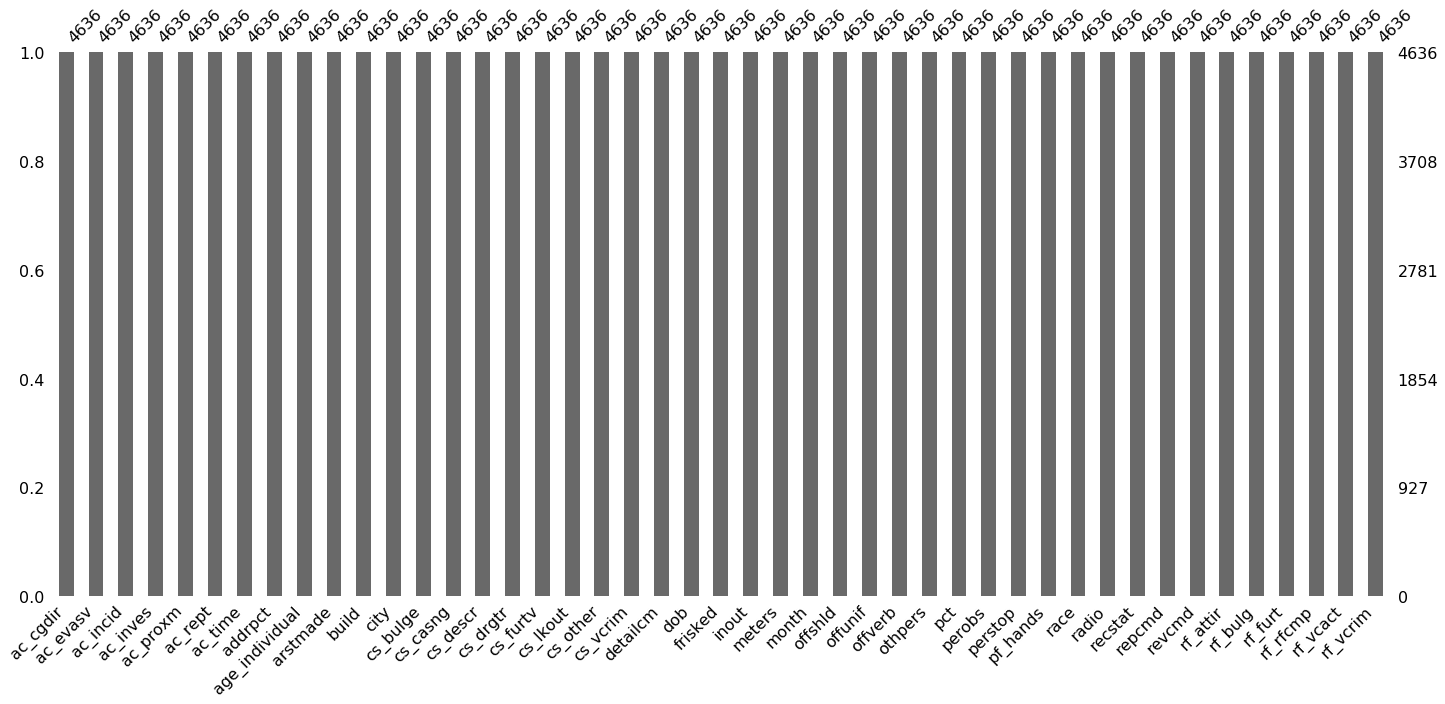

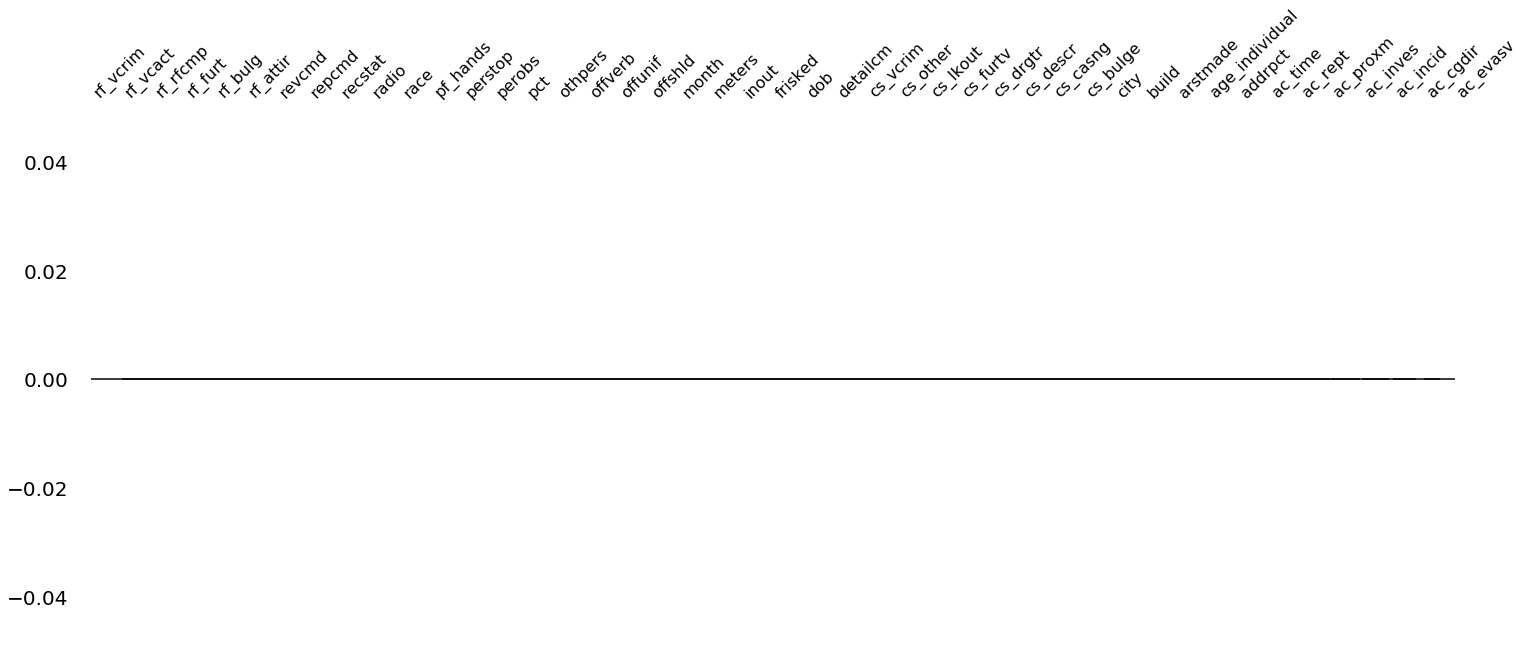

In [41]:
#Graficar datos perdidos - Columnas de 1 a 45
#msno.matrix(df_train_pp)
msno.bar(df_train_pp.iloc[:,:45])
msno.dendrogram(df_train_pp.iloc[:,:45])
plt.show()

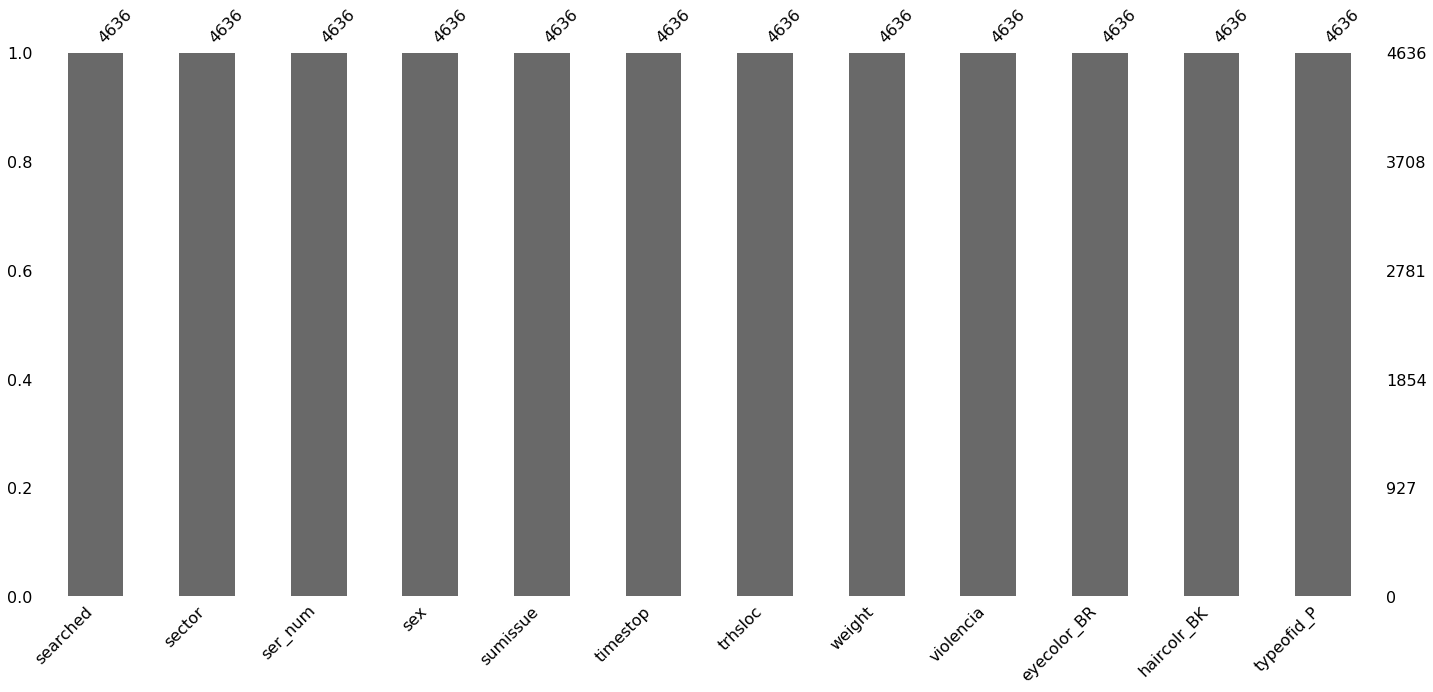

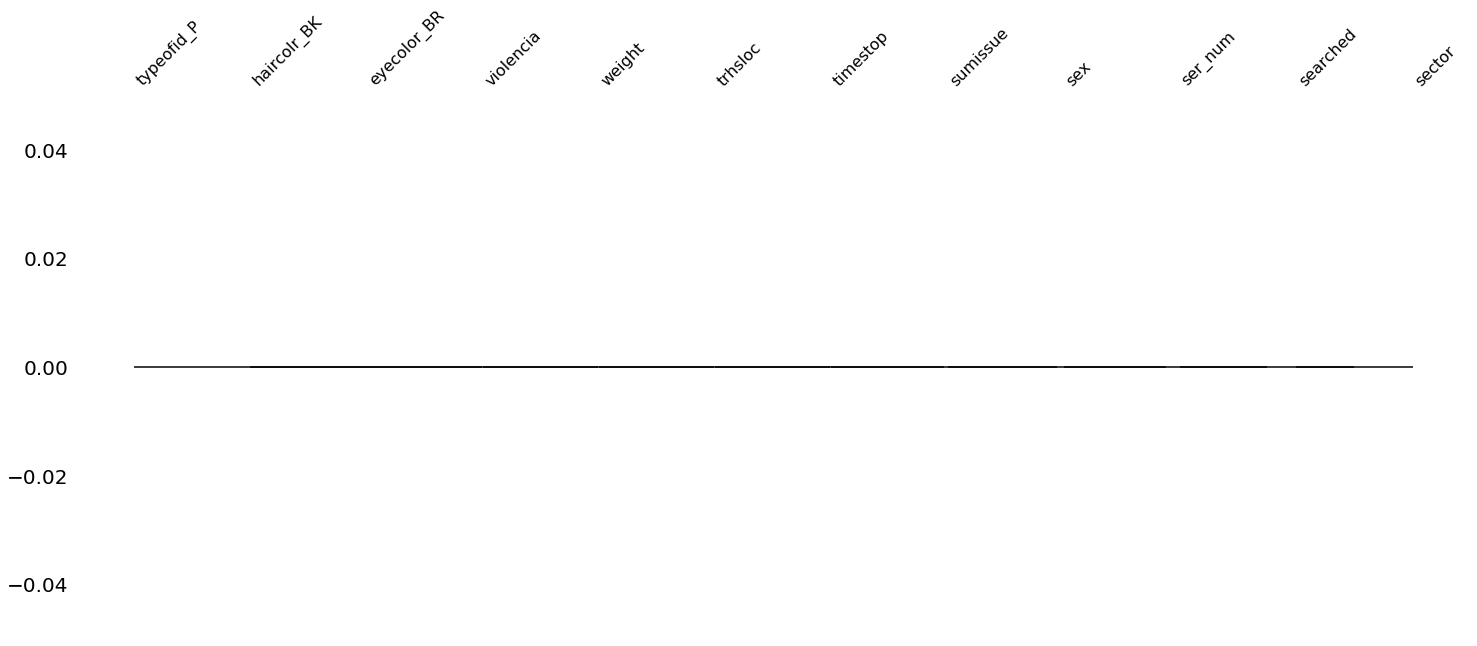

In [42]:
#Graficar datos perdidos - Columnas de 46 a 90
#msno.matrix(df_train_pp)
msno.bar(df_train_pp.iloc[:,45:])
msno.dendrogram(df_train_pp.iloc[:,45:])
plt.show()

- Base de datos de validación(2010):

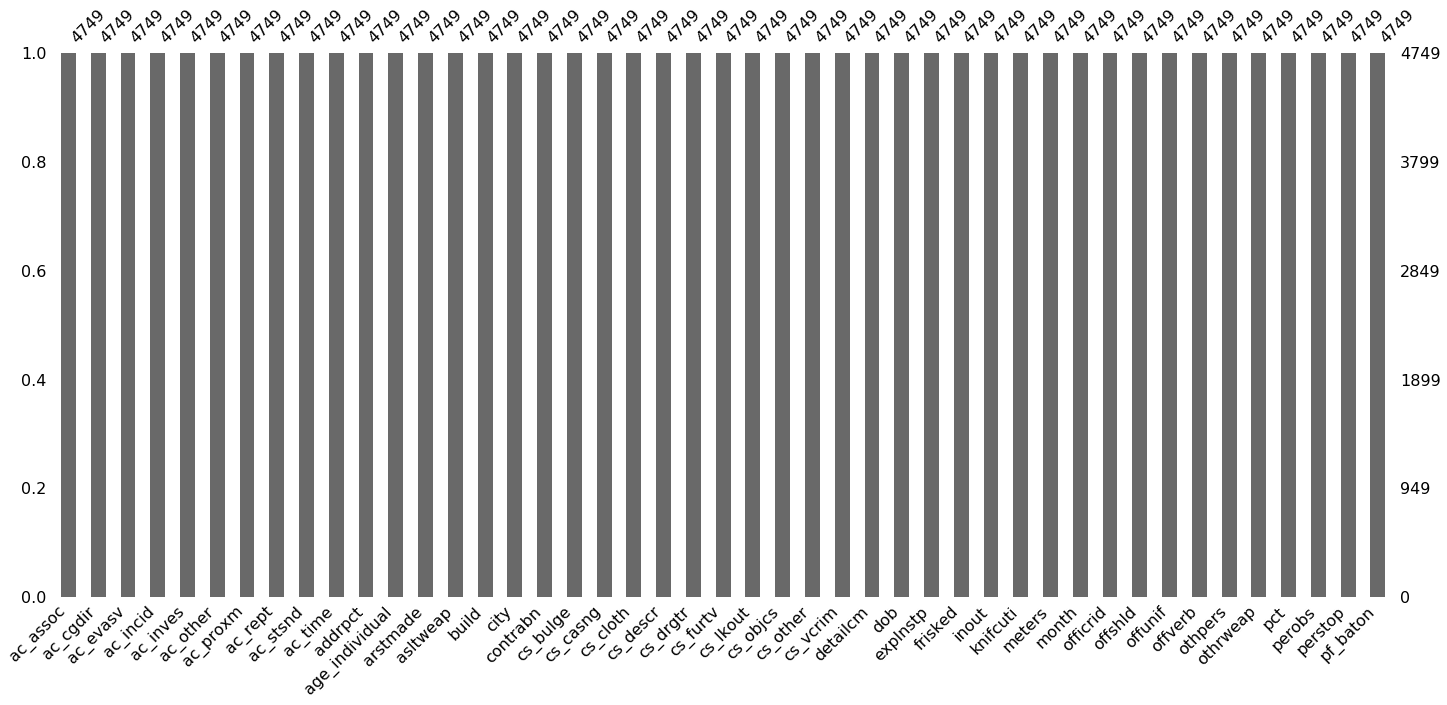

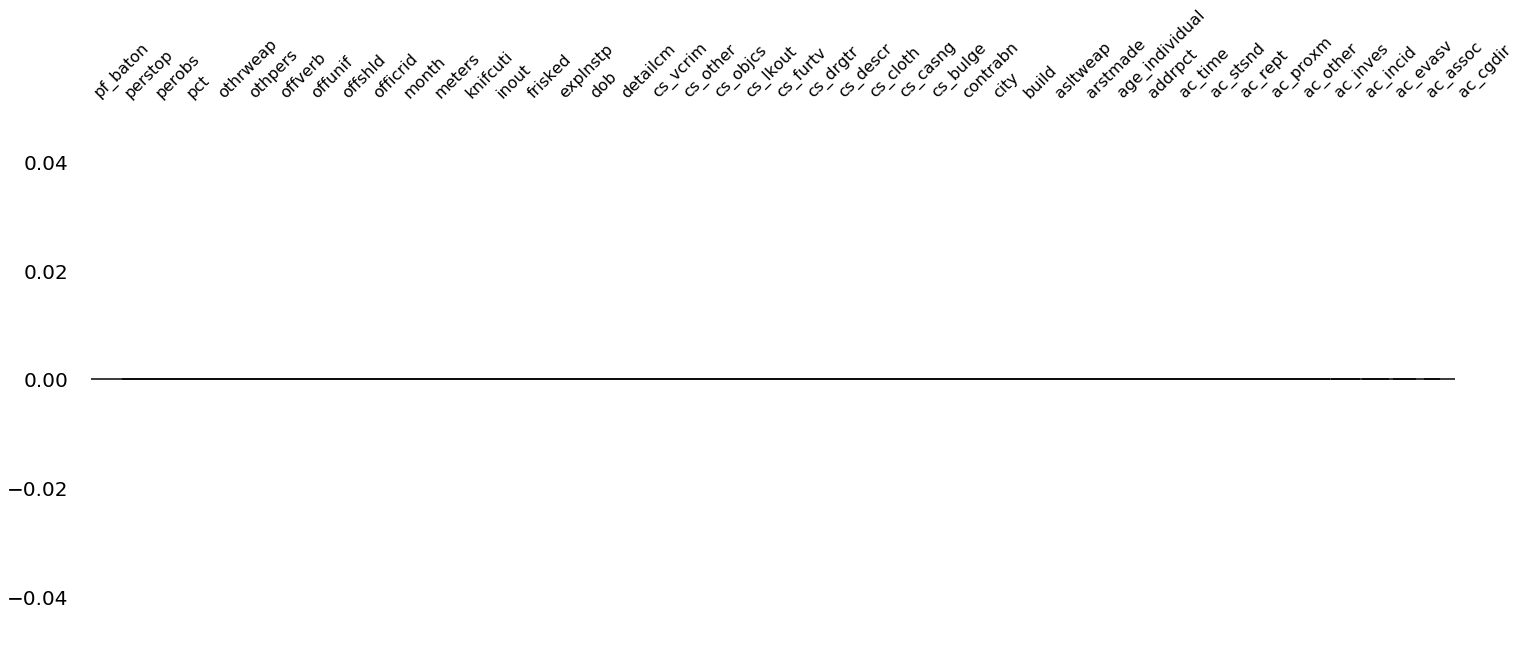

In [43]:
#Graficar datos perdidos - Columnas de 1 a 45
#msno.matrix(df_train_pp)
msno.bar(df_test_pp.iloc[:,:45])
msno.dendrogram(df_test_pp.iloc[:,:45])
plt.show()

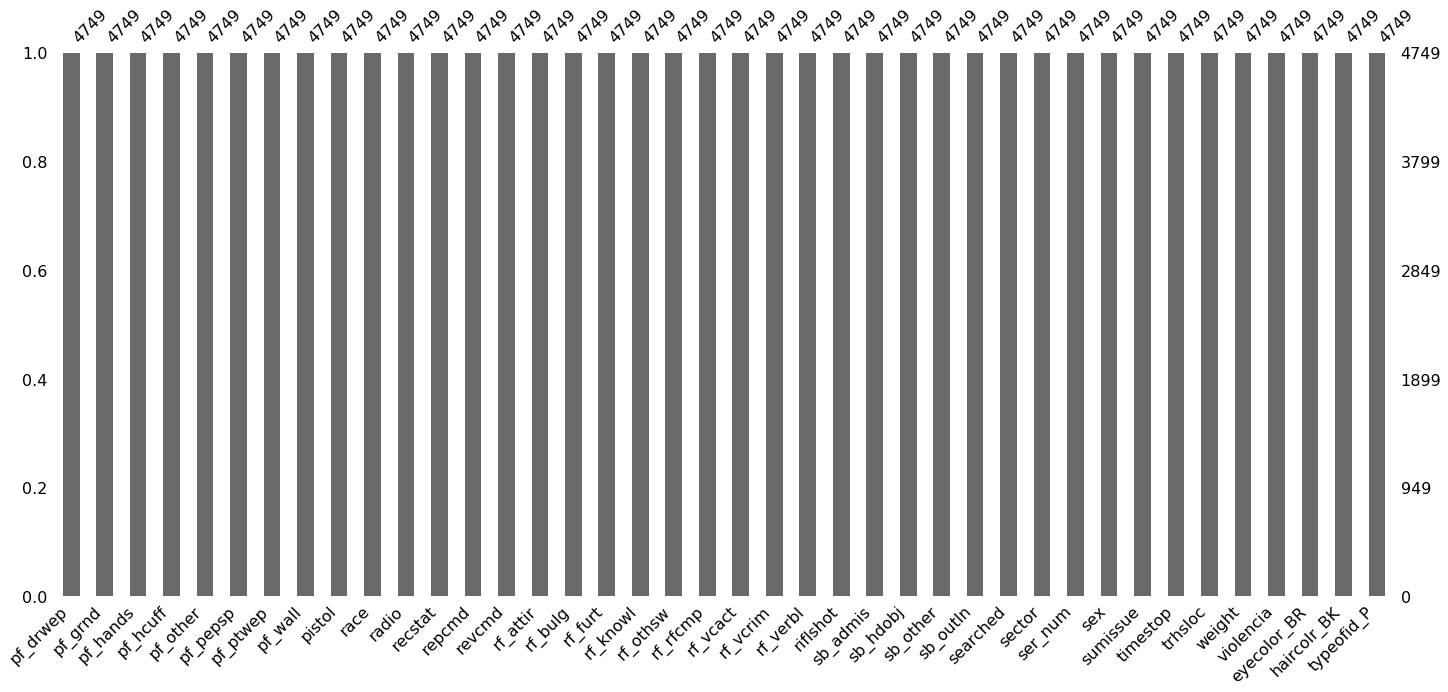

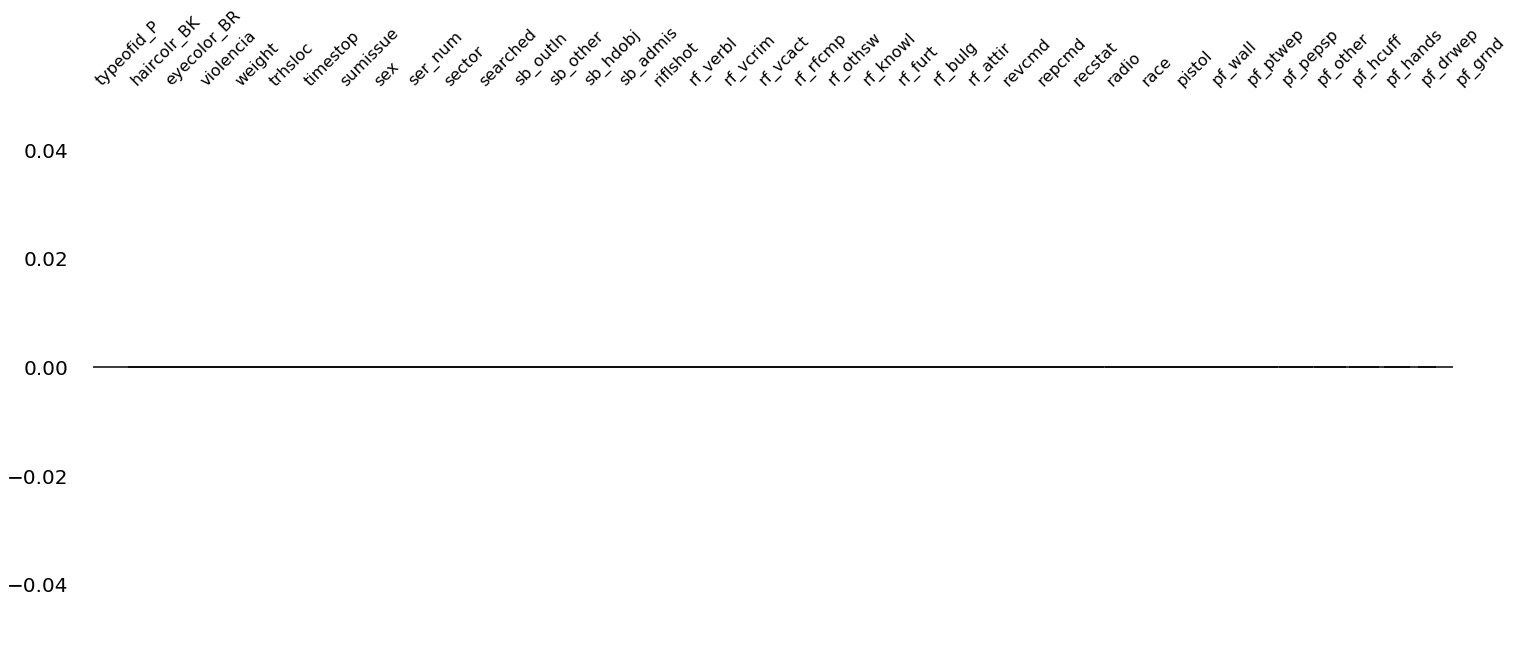

In [44]:
#Graficar datos perdidos - Columnas de 46 a 90
#msno.matrix(df_train_pp)
msno.bar(df_test_pp.iloc[:,45:])
msno.dendrogram(df_test_pp.iloc[:,45:])
plt.show()

Se observa que las únicas columnas con más del 50% de los datos perdidos son 'beat' y 'post', por lo que serán retiradas. La siguiente columna con mayor porcentaje de datos perdidos es 'age_individual', con alrededor de un 20% de los datos. Como antes del procesamiento esta columna no tenian NaN, significa que las entradas con datos perdidos corresponden a personas menores a 18 años o mayores a 100 años (según el filtro de procesamiento entregado), por lo tanto no pueden utilizarse en el análisis y serán retiradas.

In [45]:
#Eliminando columnas 'beat' y 'post'
df_train_pp.drop(columns = ['beat', 'post'], inplace = True)
df_test_pp.drop(columns = ['beat', 'post'], inplace = True)
# Eliminando del listado de variables
df_train_sca.remove('beat')
df_train_sca.remove('post')

KeyError: "['beat' 'post'] not found in axis"

In [ ]:
# Eliminando entradas de 'age_individual'
df_train_pp.dropna(subset = ['age_individual'], inplace=True)
df_test_pp.dropna(subset = ['age_individual'], inplace=True)

In [ ]:
#Revisemos cuantos valores na existen:
try:
    na_columns_list = []
    for index,value in enumerate(df_train_pp):
        if df_train_pp[value].isna().value_counts("%")[0] < 1.0:
            na_columns_list.append(value)
    sns.barplot(x=df_train_pp[na_columns_list].isna().sum(),y=na_columns_list)
except:
    print("No existen NaN:", df_train_pp.shape == df_train_pp.dropna().shape) 

### Análisis del vector objetivo
Se debe resolver la predicción de dos problemas, donde cada cual cuenta con su propio vector objetivo.
- Procedimientos policiales que terminan en arrestos: En este caso el vector objetivo es la columna 'arstmade'

In [ ]:
plt.figure(figsize=(6,2))
sns.countplot(df_train_pp['arstmade']);
plt.xlabel('¿Ocurrió un arresto?')
plt.ylabel('Cantidad de ocurrencias');
plt.show()
#round(df_train_pp['arstmade'].value_counts('%'),2)

El vector objetivo es desbalanceado, la candidad de casos que no terminan en arresto corresponden al 94%, mientras que los arrestos son el 6%. Esto puede indicar que el desempeño del modelo no posea tanta información para identificar correctamente los casos positivos de arresto.

- Procedimientos policiales que concluyeron en una acción violenta: En este caso el vector objetivo se debe crear en función de otros atributos indicadores de situaciones violentas ('pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_baton','pf_hcuff', 'pf_pepsp', 'pf_other'). El vector se llamará 'violencia'.

In [ ]:
casos_violentos = (df_train_pp['pf_hands']=='Y') | (df_train_pp['pf_wall']=='Y')|(df_train_pp['pf_grnd']=='Y')|(df_train_pp['pf_drwep']=='Y')|(df_train_pp['pf_baton']=='Y')|(df_train_pp['pf_hcuff']=='Y')|(df_train_pp['pf_pepsp']=='Y')|(df_train_pp['pf_other']=='Y')
df_train_pp['violencia'] = np.where(casos_violentos, 'Y', 'N')

In [ ]:
plt.figure(figsize=(6,2))
sns.countplot(df_train_pp['violencia']);
plt.xlabel('¿Procedimiento fue violento?')
plt.ylabel('Cantidad de ocurrencias');
plt.show()
#round(df_train_pp['violencia'].value_counts('%'),2)

En este caso las clases también están desbalanceadas, donde un 25% de los procedimientos concluyó en acciones violentas. Es posible que esto disminuya la capacidad de predicción de valores positivos en los modelos. 

El mismo vector será creado en la matriz de validación:

In [ ]:
casos_violentos = (df_test_pp['pf_hands']=='Y') | (df_test_pp['pf_wall']=='Y')|(df_test_pp['pf_grnd']=='Y')|(df_test_pp['pf_drwep']=='Y')|(df_test_pp['pf_baton']=='Y')|(df_test_pp['pf_hcuff']=='Y')|(df_test_pp['pf_pepsp']=='Y')|(df_test_pp['pf_other']=='Y')
df_test_pp['violencia'] = np.where(casos_violentos, 'Y', 'N')

### Análisis exploratorio de otras variables
A continuación se presenta el comportamiento de las otras variables de la base de datos de entrenamiento.

In [ ]:
categoricos = df_train_sca.copy()
categoricos.remove('arstmade')
numericos = df_train_sna
print(f'Las variables categóricas son:\n{categoricos}\n')

In [ ]:
#Analisis Exploratorio de variables categóricas
n_columns_bin = 7
n_columns_nobin = 2
n_rows = len(categoricos)/ n_columns_bin
count = 0
sub_index = 0
sns.set_palette("dark")

#Plotear variables con pocos casos, de forma comprimida
plt.figure(figsize=(16, 2 * n_rows))
for values in categoricos:
    if len(df_train_pp[values].value_counts()) <= 2:
        plt.subplot(1 + n_rows, n_columns_bin, sub_index + 1)
        sns.countplot(df_train_pp[values])
        sub_index += 1
        count += 1
plt.tight_layout()
plt.show()

#Plotear variables con multiples casos, de forma extendida
sub_index = 0
n_rows = int((len(categoricos) - count) / n_columns_nobin)
plt.figure(figsize=(16, 2 * n_rows))
for values in categoricos:
    if (len(df_train_pp[values].value_counts()) > 2):
        plt.subplot(1 + n_rows, n_columns_nobin, sub_index + 1)
        sns.countplot(df_train_pp[values])
        sub_index += 1
plt.tight_layout()
plt.show()

Se observa que la mayor parte de las variables categóricas están desbalanceadas. 

In [ ]:
#Se hacen las binarizaciones, reemplazos adecuados, buscando no contar con categorías desbalanceadas

df_train_pp['eyecolor_BR'] = np.where(df_train_pp['eyecolor'] == "BR", 1, 0)
df_test_pp['eyecolor_BR'] = np.where(df_test_pp['eyecolor'] == "BR", 1, 0)
df_train_pp = df_train_pp.drop(columns=['eyecolor'])
df_test_pp = df_test_pp.drop(columns=['eyecolor'])
categoricos.append('eyecolor_BR')
categoricos.remove('eyecolor')

df_train_pp['haircolr_BK'] = np.where(df_train_pp['haircolr'] == "BK", 1, 0)
df_test_pp['haircolr_BK'] = np.where(df_test_pp['haircolr'] == "BK", 1, 0)
df_train_pp = df_train_pp.drop(columns=['haircolr'])
df_test_pp = df_test_pp.drop(columns=['haircolr'])
categoricos.append('haircolr_BK')
categoricos.remove('haircolr')

df_train_pp['typeofid_P'] = np.where(df_train_pp['typeofid'] == "P", 1, 0)
df_test_pp['typeofid_P'] = np.where(df_test_pp['typeofid'] == "P", 1, 0)
df_train_pp = df_train_pp.drop(columns=['typeofid'])
df_test_pp = df_test_pp.drop(columns=['typeofid'])
categoricos.append('typeofid_P')
categoricos.remove('typeofid')

df_train_pp['trhsloc'].replace(['P','NA'],'OT', inplace=True)
df_test_pp['trhsloc'].replace(['P','NA'],'OT', inplace=True)

df_train_pp['build'].replace(['U','NA'],'OT', inplace=True)
df_test_pp['build'].replace(['U','NA'],'OT', inplace=True)

df_train_pp['race'].replace(['O','P'],'LA', inplace=True) #Latino
df_test_pp['race'].replace(['O','P'],'LA', inplace=True) #Latino
df_train_pp['race'] = np.where((df_train_pp['race'] == "B") | (df_train_pp['race'] == "W") | (df_train_pp['race'] == "LA"), df_train_pp['race'] , "OT")
df_test_pp['race'] = np.where((df_test_pp['race'] == "B") | (df_test_pp['race'] == "W") | (df_test_pp['race'] == "LA"), df_test_pp['race'] , "OT")

#### SACAR ATRIBUTOS BINARIOS EXCESIVAMENTE DESBALANCEADAS (5%)

In [ ]:
df_train_pp.columns

In [46]:
for index, value in enumerate(categoricos):
    try:
        if (len(df_train_pp[value].value_counts()) >= 2):  
            if df_train_pp[value].value_counts("%")[0]>= 0.95:
                print(value)  
                df_train_pp = df_train_pp.drop(columns = value)
        elif (len(df_train_pp[value].value_counts()) == 1):
            if df_train_pp[value].value_counts("%")[1]>= 0.95:
                print(value)  
                df_train_pp = df_train_pp.drop(columns = value)
    except:
        print(f"error: {value}")

In [47]:
print(f'Las variables numéricas son:\n{numericos}')

Las variables numéricas son:
['addrpct', 'age_individual', 'detailcm', 'dob', 'meters', 'month', 'pct', 'perobs', 'perstop', 'repcmd', 'revcmd', 'ser_num', 'timestop', 'weight']


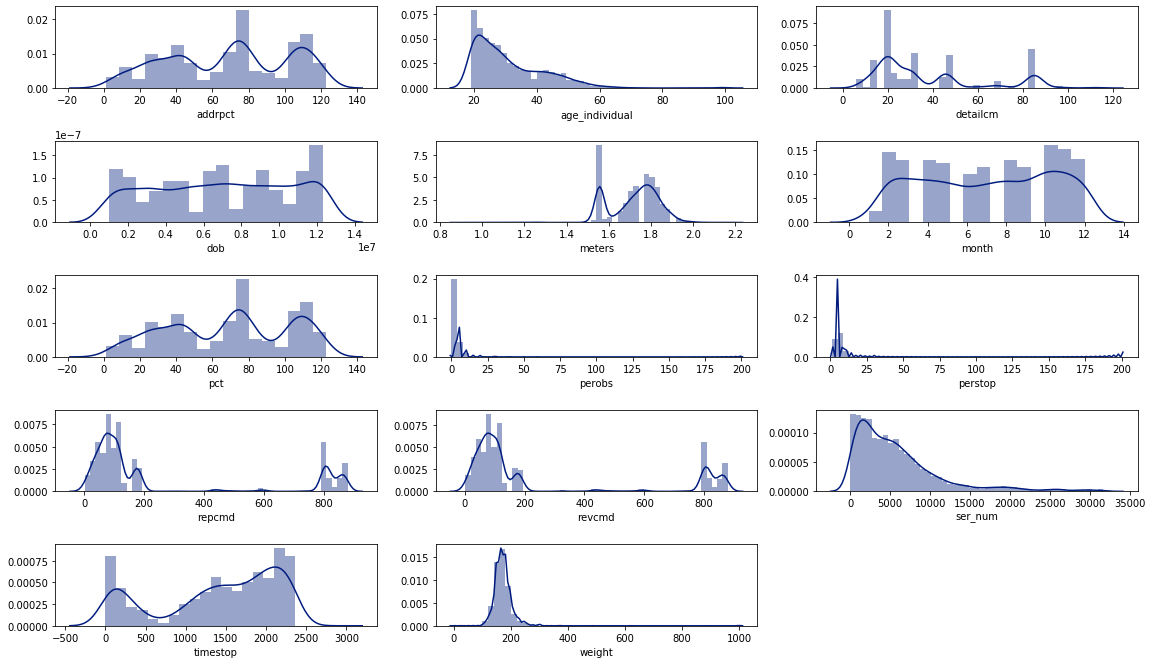

In [48]:
#Analisis Exploratorio de variables numéricas
n_columns_num = 3
n_rows = len(numericos) / n_columns_num
sub_index = 0
sns.set_palette("dark")

plt.figure(figsize=(16, 2 * n_rows))
for values in numericos:
    plt.subplot(1 + n_rows, n_columns_num, sub_index + 1)
    sns.distplot(df_train_pp[values].dropna())
    sub_index += 1
plt.tight_layout()
plt.show()

### SE PODRÌA HACER BOXPLOT PARA VER TENDENCIAS
### ABAJO HAY UNA CELDA CON LOGARITMOS

Las variables year, compyear, comppct, linecm, son constantes por lo que se eliminarán del set de datos.

In [49]:
#Eliminando columnas 'beat' y 'post'
df_train_pp.drop(columns = ['year', 'compyear', 'comppct', 'linecm'], inplace = True)
df_test_pp.drop(columns = ['year', 'compyear', 'comppct', 'linecm'], inplace = True)

#Eliminando del listado de variables
numericos.remove('year')
numericos.remove('compyear')
numericos.remove('comppct')
numericos.remove('linecm')

KeyError: "['year' 'compyear' 'comppct' 'linecm'] not found in axis"

In [ ]:
#Actualizar lista categoricos
fset_cat = frozenset(categoricos)
fset_num = frozenset(numericos)

categoricos = [x for x in df_train_pp.columns if x in fset_cat]
numericos = [x for x in df_train_pp.columns if x in fset_num]

for index, value in enumerate(df_test_pp):
    if value not in df_train_pp.columns:
        try:
            df_test_pp.drop(value)
        except:
            print(f"Atributo _{value}_ no se encuentra en df_test_pp")

### Recodificación de variables categóricas
- Vectores objetivo:  
Serán recodificados en columnas de valores 0 y 1.

In [50]:
vo_train_bin = recodeToBinary(df_train_pp[['arstmade','violencia']])
vo_test_bin = recodeToBinary(df_test_pp[['arstmade','violencia']])

In [51]:
vo_train_bin.sample(2)

,arstmade_Y,violencia_Y
3304,0,0
541335,0,0


- Atributos:  
Se recodificarán las columnas de atributos creando k-1 variables dummies con valores 0 y 1.

In [52]:
# Recodificando variables categoricas
at_train_bin = recodeToBinary(df_train_pp.loc[:,categoricos])
at_test_bin = recodeToBinary(df_test_pp.loc[:,categoricos])
print(at_train_bin.shape)
print(at_test_bin.shape)

(4636, 64)
(4749, 64)


In [53]:
# Juntando variables recodificadas con las numéricas
at_train_bin = pd.concat([at_train_bin, df_train_pp.loc[:,numericos]], axis=1)
at_test_bin = pd.concat([at_test_bin, df_test_pp.loc[:,numericos]], axis=1)
print(at_train_bin.shape)
print(at_test_bin.shape)

(4636, 78)
(4749, 78)


In [54]:
# Ejemplo set de entrenamiento
at_train_bin.sample(2)

,ac_cgdir_Y,ac_evasv_Y,ac_incid_Y,ac_inves_Y,ac_proxm_Y,ac_rept_Y,ac_time_Y,build_M,build_OT,build_T,city_BROOKLYN,city_MANHATTAN,city_QUEENS,city_STATEN ISLAND,cs_bulge_Y,cs_casng_Y,cs_descr_Y,cs_drgtr_Y,cs_furtv_Y,cs_lkout_Y,cs_other_Y,cs_vcrim_Y,frisked_Y,inout_O,offshld_Y,offunif_Y,offverb_Y,othpers_Y,pf_hands_Y,race_LA,race_OT,race_W,radio_Y,recstat_A,rf_attir_Y,rf_bulg_Y,rf_furt_Y,rf_rfcmp_Y,rf_vcact_Y,rf_vcrim_Y,searched_Y,sector_B,sector_C,sector_D,sector_E,sector_F,sector_G,sector_H,sector_I,sector_J,sector_K,sector_M,sector_N,sector_NA,sector_P,sector_Q,sector_R,sector_T,sector_U,sex_M,sex_NA,sumissue_Y,trhsloc_OT,trhsloc_T,addrpct,age_individual,detailcm,dob,meters,month,pct,perobs,perstop,repcmd,revcmd,ser_num,timestop,weight
422281,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,32,46.0,31,3101963,1.73736,9,32,1.0,2,806,806,7721,1322,180
182043,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,110,23.0,20,8021985,1.76784,4,110,1.0,1,110,110,3722,40,180


In [55]:
# Retirando NaN de set de datos.
at_train_bin.dropna(inplace = True)
at_test_bin.dropna(inplace = True)
print(at_train_bin.shape)
print(at_test_bin.shape)

(4636, 78)
(4749, 78)


### Correlación de variables
En caso de que existan pares de variables de alta correlación (sobre 80%), se debe retirar una para evitar multicolinealidad.  Dado que no se asegura normalidad de las variables se utilizará la correlación no-paramétrica de spearman.

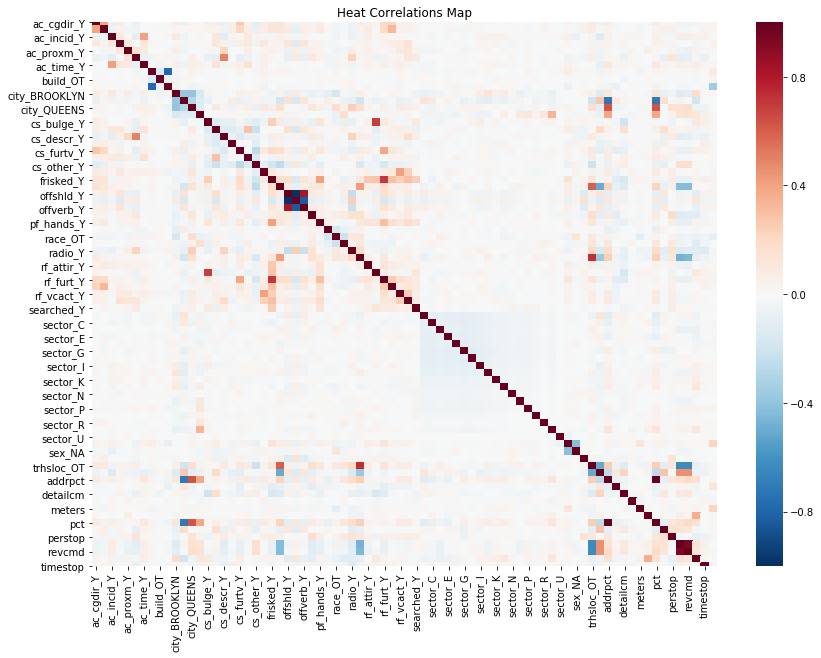

In [56]:
corr_matrix = at_train_bin.corr(method='spearman')
plt.figure(figsize=(14,10))
plt.title("Heat Correlations Map")
sns.heatmap(corr_matrix, cmap='RdBu_r', annot=False, vmin =-1, vmax=1, center=0 );

In [57]:
print('Como criterio de alta correlación, se considerarán valores mayores o iguales a +-0.8.')
print('Los pares de variables que cumplen con dicha correlación son:')
triangulo_corr = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(np.bool)) # Triangulo superior de matriz
triangulo_corr = triangulo_corr.stack()     # Par de valores por correlación
triangulo_corr[abs(triangulo_corr) >= 0.8]  # Dejar valores sobre el criterio

Como criterio de alta correlación, se considerarán valores mayores o iguales a +-0.8.
Los pares de variables que cumplen con dicha correlación son:


offshld_Y  offunif_Y   -0.989995
           offverb_Y    0.825724
offunif_Y  offverb_Y   -0.836917
addrpct    pct          1.000000
repcmd     revcmd       0.942755
dtype: float64

Se eliminarán las variables 'offshld_Y', 'offverb_Y', 'addrpct', 'repcmd'.

In [58]:
at_train_bin.drop(columns=['offshld_Y','offverb_Y', 'addrpct', 'repcmd'], inplace = True)
at_test_bin.drop(columns=['offshld_Y','offverb_Y', 'addrpct', 'repcmd'], inplace = True)

In [59]:
at_train_bin.columns

Index(['ac_cgdir_Y', 'ac_evasv_Y', 'ac_incid_Y', 'ac_inves_Y', 'ac_proxm_Y',
       'ac_rept_Y', 'ac_time_Y', 'build_M', 'build_OT', 'build_T',
       'city_BROOKLYN', 'city_MANHATTAN', 'city_QUEENS', 'city_STATEN ISLAND',
       'cs_bulge_Y', 'cs_casng_Y', 'cs_descr_Y', 'cs_drgtr_Y', 'cs_furtv_Y',
       'cs_lkout_Y', 'cs_other_Y', 'cs_vcrim_Y', 'frisked_Y', 'inout_O',
       'offunif_Y', 'othpers_Y', 'pf_hands_Y', 'race_LA', 'race_OT', 'race_W',
       'radio_Y', 'recstat_A', 'rf_attir_Y', 'rf_bulg_Y', 'rf_furt_Y',
       'rf_rfcmp_Y', 'rf_vcact_Y', 'rf_vcrim_Y', 'searched_Y', 'sector_B',
       'sector_C', 'sector_D', 'sector_E', 'sector_F', 'sector_G', 'sector_H',
       'sector_I', 'sector_J', 'sector_K', 'sector_M', 'sector_N', 'sector_NA',
       'sector_P', 'sector_Q', 'sector_R', 'sector_T', 'sector_U', 'sex_M',
       'sex_NA', 'sumissue_Y', 'trhsloc_OT', 'trhsloc_T', 'age_individual',
       'detailcm', 'dob', 'meters', 'month', 'pct', 'perobs', 'perstop',
       'revcmd', '

In [60]:
#Actualizar lista categoricos
fset_cat = frozenset(categoricos)
fset_num = frozenset(numericos)

categoricos = [x for x in df_train_pp.columns if x in fset_cat]
numericos = [x for x in df_train_pp.columns if x in fset_num]

for index, value in enumerate(df_test_pp):
    if value not in df_train_pp.columns:
        try:
            df_test_pp.drop(value)
        except:
            print(f"Atributo _{value}_ no se encuentra en df_test_pp")

Atributo _ac_assoc_ no se encuentra en df_test_pp
Atributo _ac_other_ no se encuentra en df_test_pp
Atributo _ac_stsnd_ no se encuentra en df_test_pp
Atributo _asltweap_ no se encuentra en df_test_pp
Atributo _contrabn_ no se encuentra en df_test_pp
Atributo _cs_cloth_ no se encuentra en df_test_pp
Atributo _cs_objcs_ no se encuentra en df_test_pp
Atributo _explnstp_ no se encuentra en df_test_pp
Atributo _knifcuti_ no se encuentra en df_test_pp
Atributo _officrid_ no se encuentra en df_test_pp
Atributo _othrweap_ no se encuentra en df_test_pp
Atributo _pf_baton_ no se encuentra en df_test_pp
Atributo _pf_drwep_ no se encuentra en df_test_pp
Atributo _pf_grnd_ no se encuentra en df_test_pp
Atributo _pf_hcuff_ no se encuentra en df_test_pp
Atributo _pf_other_ no se encuentra en df_test_pp
Atributo _pf_pepsp_ no se encuentra en df_test_pp
Atributo _pf_ptwep_ no se encuentra en df_test_pp
Atributo _pf_wall_ no se encuentra en df_test_pp
Atributo _pistol_ no se encuentra en df_test_pp
Atri

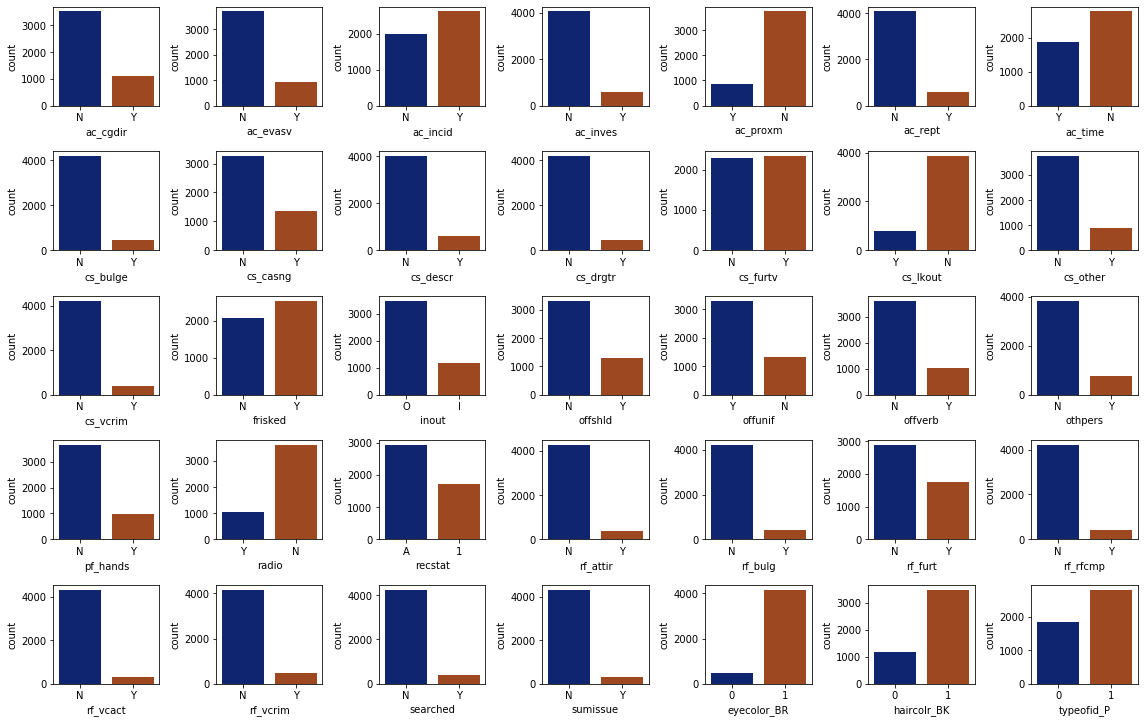

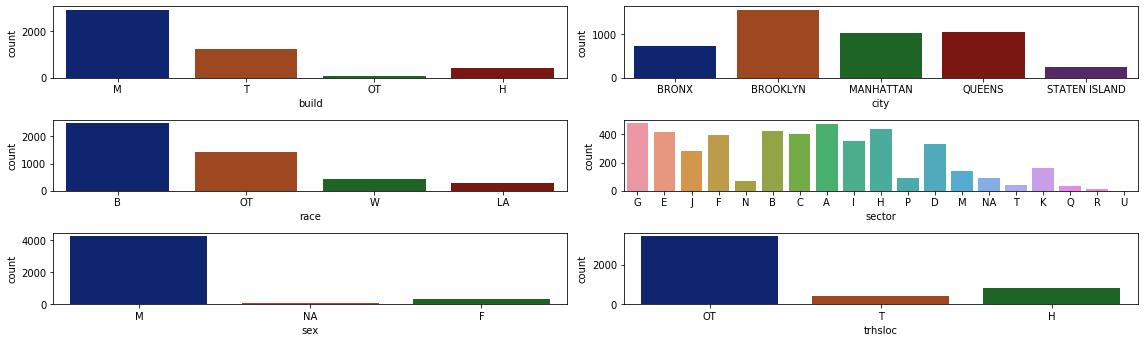

In [61]:
#Analisis Exploratorio de variables categóricas
n_columns_bin = 7
n_columns_nobin = 2
n_rows = len(categoricos)/ n_columns_bin
count = 0
sub_index = 0
sns.set_palette("dark")

#Plotear variables con pocos casos, de forma comprimida
plt.figure(figsize=(16, 2 * n_rows))
for values in categoricos:
    if len(df_train_pp[values].value_counts()) <= 2:
        plt.subplot(1 + n_rows, n_columns_bin, sub_index + 1)
        sns.countplot(df_train_pp[values])
        sub_index += 1
        count += 1
plt.tight_layout()
plt.show()

#Plotear variables con multiples casos, de forma extendida
sub_index = 0
n_rows = int((len(categoricos) - count) / n_columns_nobin)
plt.figure(figsize=(16, 2 * n_rows))
for values in categoricos:
    if (len(df_train_pp[values].value_counts()) > 2):
        plt.subplot(1 + n_rows, n_columns_nobin, sub_index + 1)
        sns.countplot(df_train_pp[values])
        sub_index += 1
plt.tight_layout()
plt.show()

In [62]:
print('Ya hemos concluido el preprocesamiento. \nLas dimensiones de cada base se redujeron de la siguiente manera:')
pd.DataFrame({'Datos de entrenamiento': [df_train.shape, at_train_bin.shape], 
                      'Datos de validación': [df_test.shape, at_test_bin.shape]},
                    index=['Shape dataframe cruda', 'Shape dataframe procesada'])

Ya hemos concluido el preprocesamiento. 
Las dimensiones de cada base se redujeron de la siguiente manera:


,Datos de entrenamiento,Datos de validación
Shape dataframe cruda,"(5812, 111)","(6013, 111)"
Shape dataframe procesada,"(4636, 74)","(4749, 74)"


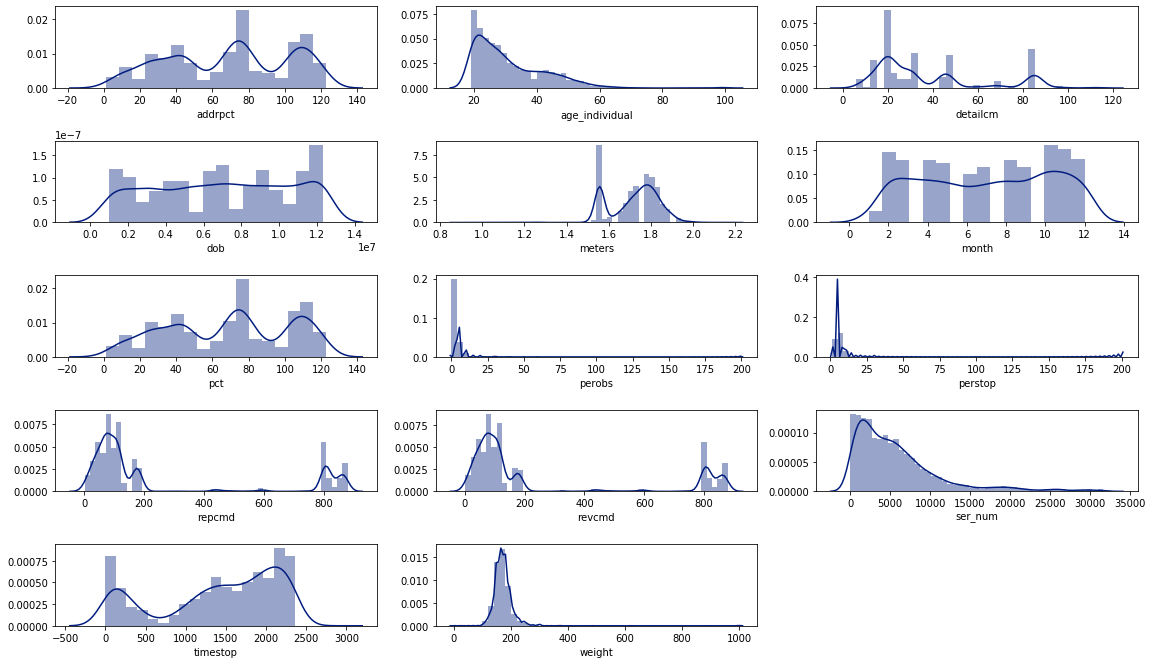

In [63]:
#Analisis Exploratorio de variables numéricas
n_columns_num = 3
n_rows = len(numericos) / n_columns_num
sub_index = 0
sns.set_palette("dark")

plt.figure(figsize=(16, 2 * n_rows))
for values in numericos:
    plt.subplot(1 + n_rows, n_columns_num, sub_index + 1)
    sns.distplot(df_train_pp[values].dropna())
    sub_index += 1
plt.tight_layout()
plt.show()

## 3. Modelación: Procedimientos policiales que terminan en arrestos
Generar un modelo predictivo que condicional a las características medidas del sospechoso, prediga si un determinado procedimiento concluirá en un arresto o no. Para ello, guíase por los siguentes lineamientos:

- Entrene por lo menos 1 modelo que sea capaz de predecir si se producirá un arresto o no. Una vez que encuentre un modelo satisfactorio, reporte al menos dos métricas de desempeño.
- Refine aquellos atributos relevantes. Encuentre por lo menos 30 atributos que explique la importancia relativa y ordénelos por orden de importancia.
- Finalmente, reporte la probabilidad que un individuo sea arrestado en uno de los cinco barrios, condicional al género y condicional a la raza.

---

Se evaluarán 3 modelos para encontrar uno satisfactorio y se reportarán dos métricas de desempeño. Los modelos a utilizar serán:
- Regresión Logística
- Support Vector Cassifier
- Ramdom Forest

Dado que en este problema el objetivo es predecir si una persona será arrestada o no (en un procedimiento policial), consideramos que es muy importante evaluar la calidad de desempeño frente a los errores asociados a arrestar a una persona 'que no debería ser arrestada' según los parámetros estudiados. En base a esta consideración se utilizará la métrica __Recall__, y como segunda métrica se usará __ROC Score__, ya que entrega una buena visión de los resultados de predicción, en especial cuando existen clases desbalanceadas.

### Entrenamiento de modelo y reporte de métricas de desempeño
Para desarrollar el modelo se separará la muestra del año 2009 en un set de entrenamiento y uno de validación. Posteriormente, una vez desarrolladas todos los ensayos se realizará la prueba con el set del año 2010.

In [36]:
#Separación de base de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(at_train_bin,vo_train_bin["arstmade_Y"],test_size=.33,random_state=180919)
X_list = at_train_bin.columns.tolist()
y_test = vo_test_bin["arstmade_Y"]

In [37]:
# Estandarización la matriz de entrenamiento, de validación y de la muestra de prueba (año 2010)
X_train_std = StandardScaler().fit_transform(X_train)
X_val_std = StandardScaler().fit_transform(X_val)
X_test_std = StandardScaler().fit_transform(at_test_bin)

In [38]:
# Modelos Básicos
logit_model = LogisticRegression(random_state=180919)
logit_model.fit(X_train_std, y_train)

lsvc_model = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', dual=False, random_state=180919), cv=5)
lsvc_model.fit(X_train_std, y_train)

rndFrst_model = RandomForestClassifier(random_state=180919)
rndFrst_model.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=180919,
                       verbose=0, warm_start=False)

#### Veamos como se desarrollan las métricas para los valores de entrenamiento y de validación.

In [39]:
# Desarrollo de predicciones 
yhat_logit = logit_model.predict(X_val_std)
yhat_lsvc = lsvc_model.predict(X_val_std)
yhat_rndFrst = rndFrst_model.predict(X_val_std)
# Cálculo de las métricas
recall_logit = recall_score(y_val, yhat_logit)
recall_lsvc = recall_score(y_val, yhat_lsvc)
recall_rndFrst  = recall_score(y_val, yhat_rndFrst)

print('\033[1mEl desempeño de los modelos en base a la métrica Recall es:\033[0m')
metric = pd.DataFrame({'Logit': [recall_logit], 'SVC': [recall_lsvc], 'RF':[recall_rndFrst]}, index=['Recall'])
round(metric,2)

El desempeño de los modelos en base a la métrica Recall es:


,Logit,SVC,RF
Recall,0.42,0.39,0.13


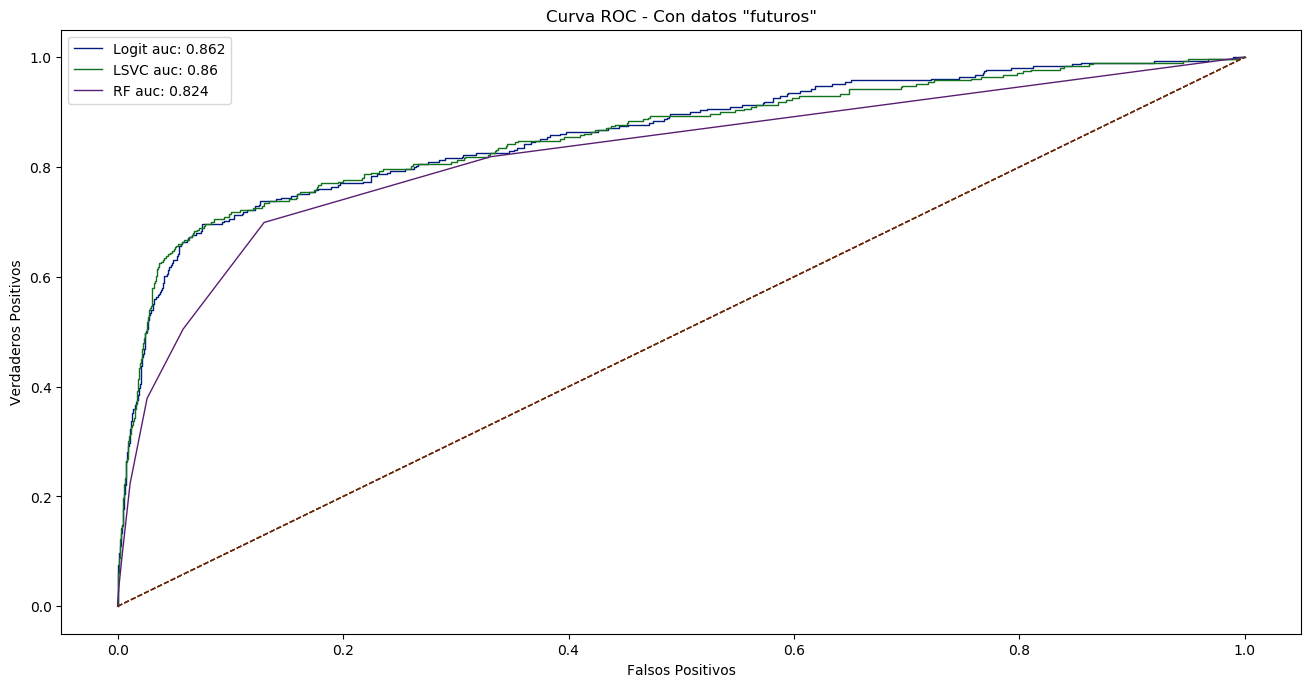

In [87]:
# Generando objetos de ROC curve
plt.figure(figsize=[16,8])
plt.title('Curva ROC - Con datos "futuros"')
for i,k in zip([logit_model,lsvc_model,rndFrst_model],['Logit','LSVC','RF']):
    a = pd.DataFrame(i.predict_proba(X_test_std))[1]
    b = pd.DataFrame(i.predict(X_test_std))
    fp, tp, th = roc_curve(y_test, a)
    recall_s  = recall_score(y_test, b)
#    print(f'\033[1mEl desempeño del modelo {k} en base a la métrica Recall es:\033[0m\n')
#    print(pd.DataFrame({k: recall_s}, index=['Recall']),"\n")
#    print(f"\n\033[1mMetricas para clases 0 y 1, modelo {k}\033[0m\n\n{classification_report(y_test,b)}\n\n")
    plt.plot(fp, tp, lw=1, label='{} auc: {}'.format(k,roc_auc_score(y_test,a).round(3)))

    plt.plot([0,1], ls='--', lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

### Veamos si los modelos mejoran sus metricas utilizando Gridsearch.

In [ ]:
# Gridsearch Regresión Logística

# Definición de parámetros de Grilla
parameters_logit = [{"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}]
logit_gs=LogisticRegression(random_state=180919)
# Búsqueda de mejor modelo
grid_logit = GridSearchCV(logit_gs,
                        parameters_logit,
                        n_jobs=-1,
                        scoring='recall',
                        verbose=500,
                        cv=10).fit(X_train_std, y_train)
# Modelo entrenado con mejor tuneo de parámetros
grid_logit_best_arr = grid_logit.best_estimator_

print(f'Los mejores parámetros son:\n{grid_logit.best_params_}')

In [ ]:
# Gridsearch Random Forest

# Definición de parámetros de Grilla
param_grid_rf = [{
    'n_estimators': [40, 45, 50, 55, 60, 65],
    'max_features': [30, 40, 50, 60, 70],
    'max_depth': [15, 25, 35, None],
    'bootstrap': [True, False],
    "criterion": ["gini", "entropy"]
}]

# Búsqueda de mejor modelo
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=180919),
                                  param_grid_rf,
                                  cv=5,
                                  scoring='recall',
                                  verbose=50,
                                  n_jobs=-1)
grid_search_rf.fit(X_train_std, y_train)

# Modelo entrenado con mejor tuneo de parámetros
grid_rf_best_arr = grid_search_rf.best_estimator_

print(f'Los mejores parámetros son:\n{grid_search_rf.best_params_}')

In [ ]:
#GridSearch LSVC

# Definición de parámetros de Grilla
parameters_gs = [{'kernel': ['linear'], 'C': [100, 250, 1000]}]
# Búsqueda de mejor modelo
grid_svc = GridSearchCV(SVC(random_state=180919),
                        parameters_gs,
                        n_jobs=-1,
                        scoring='recall',
                        verbose=500,
                        cv=5).fit(X_train_std, y_train)
# Modelo entrenado con mejor tuneo de parámetros
grid_svc_best_arr = grid_svc.best_estimator_

print(f'Los mejores parámetros son:\n{grid_svc.best_params_}')

In [91]:
# Desarrollo de testeos 
yhat_logit2 = grid_logit_best_arr.predict(X_val_std)
yhat_lsvc2 = grid_svc_best_arr.predict(X_val_std)
yhat_rndFrst2 = grid_rf_best_arr.predict(X_val_std)

# Cálculo de las métricas
recall_logit2  = recall_score(y_val, yhat_logit2)
recall_lsvc2  = recall_score(y_val, yhat_lsvc2)
recall_rndFrst2  = recall_score(y_val, yhat_rndFrst2)

lsvc2 = CalibratedClassifierCV(base_estimator=LinearSVC(penalty='l2', dual=False, C=1000, random_state=180919), cv=5)
lsvc2.fit(X_train_std, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=1000, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=180919, tol=0.0001,
                                                verbose=0),
                       cv=5, method='sigmoid')

In [92]:
print('\033[1mEl desempeño de los modelos en base a la métrica Recall para valores de testeo es:\033[0m')
metric2 = pd.DataFrame({'Logit-Tunned': [recall_logit2], 'LSVC-Tunned': [recall_lsvc2], 'RF-Tunned':[recall_rndFrst2]}, index=['Recall'])
round(metric2,2)

El desempeño de los modelos en base a la métrica Recall para valores de testeo es:


,Logit-Tunned,LSVC-Tunned,RF-Tunned
Recall,0.43,0.49,0.39


El desempeño del modelo Logit Tunned en base a la métrica Recall es:

        Logit Tunned
Recall      0.426966 

El desempeño del modelo LSVC Tunned en base a la métrica Recall es:

        LSVC Tunned
Recall     0.494382 

El desempeño del modelo RF Tunned en base a la métrica Recall es:

        RF Tunned
Recall   0.393258 



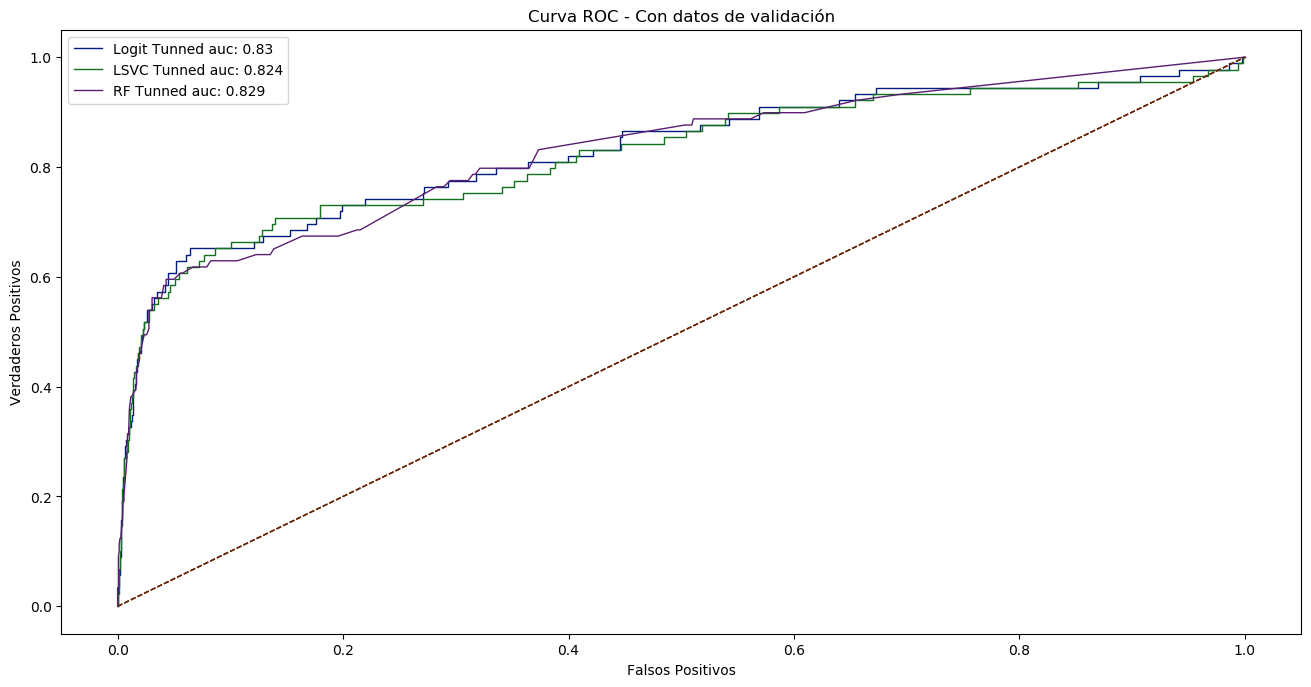

In [93]:
# Generando objetos de ROC curve
plt.figure(figsize=[16,8])
plt.title('Curva ROC - Con datos de validación')
for i,k in zip([grid_logit_best_arr,grid_svc_best_arr,grid_rf_best_arr],['Logit Tunned','LSVC Tunned','RF Tunned']):
    try:
        a = pd.DataFrame(i.predict_proba(X_val_std))[1]
    except:
        a = pd.DataFrame(lsvc2.predict_proba(X_val_std))[1]
    b = pd.DataFrame(i.predict(X_val_std))
    fp, tp, th = roc_curve(y_val, a)
    recall_s  = recall_score(y_val, b)
    print(f'\033[1mEl desempeño del modelo {k} en base a la métrica Recall es:\033[0m\n')
    print(pd.DataFrame({k: recall_s}, index=['Recall']),"\n")
#    print(f"\n\033[1mMetricas para clases 0 y 1, modelo {k}\033[0m\n\n{classification_report(y_test,b)}\n\n")
    plt.plot(fp, tp, lw=1, label='{} auc: {}'.format(k,roc_auc_score(y_val,a).round(3)))

    plt.plot([0,1], ls='--', lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

El desempeño de los 3 modelos es bastante similar y bueno si se observa los valores ROC, pero es evidente que los modelos no logran un buen rendimiento en torno a la metrica recall. De todos modos, revisemos ahora como se comporta el modelo utilizando como valores de testeo, los datos "futuros" de la base de datos del 2010

In [94]:
# Desarrollo de testeos 
yhat_logit3 = grid_logit_best_arr.predict(X_test_std)
yhat_lsvc3 = grid_svc_best_arr.predict(X_test_std)
yhat_rndFrst3 = grid_rf_best_arr.predict(X_test_std)

# Cálculo de las métricas
recall_logit3  = recall_score(y_test, yhat_logit3)
recall_lsvc3  = recall_score(y_test, yhat_lsvc3)
recall_rndFrst3  = recall_score(y_test, yhat_rndFrst3)

In [95]:
print('\033[1mEl desempeño de los modelos en base a la métrica Recall para valores "futuros" es:\033[0m')
metric3 = pd.DataFrame({'Logit-Tunned': [recall_logit3], 'LSVC-Tunned': [recall_lsvc3], 'RF-Tunned':[recall_rndFrst3]}, index=['Recall'])
round(metric3,2)

El desempeño de los modelos en base a la métrica Recall para valores "futuros" es:


,Logit-Tunned,LSVC-Tunned,RF-Tunned
Recall,0.39,0.49,0.39


NameError: name 'grid_logit_best_arr' is not defined

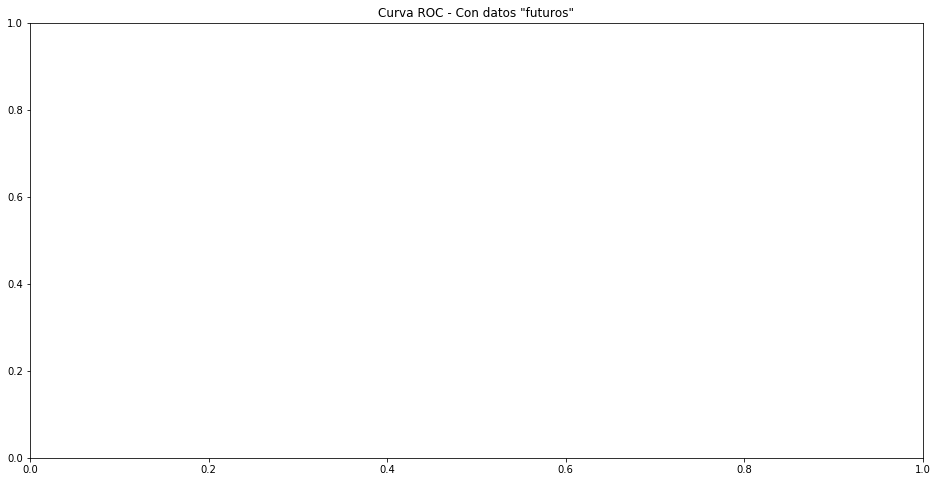

In [40]:
# Generando objetos de ROC curve
plt.figure(figsize=[16,8])
plt.title('Curva ROC - Con datos "futuros"')
for i,k in zip([grid_logit_best_arr,grid_svc_best_arr,grid_rf_best_arr],['Logit Tunned','LSVC Tunned','RF Tunned']):
    try:
        a = pd.DataFrame(i.predict_proba(X_test_std))[1]
    except:
        a = pd.DataFrame(lsvc2.predict_proba(X_test_std))[1]
    b = pd.DataFrame(i.predict(X_test_std))
    fp, tp, th = roc_curve(y_test, a)
    recall_s  = recall_score(y_test, b)
    print(f'\033[1mEl desempeño del modelo {k} en base a la métrica Recall es:\033[0m\n')
    print(pd.DataFrame({k: recall_s}, index=['Recall']),"\n")
#    print(f"\n\033[1mMetricas para clases 0 y 1, modelo {k}\033[0m\n\n{classification_report(y_test,b)}\n\n")
    plt.plot(fp, tp, lw=1, label='{} auc: {}'.format(k,roc_auc_score(y_test,a).round(3)))

    plt.plot([0,1], ls='--', lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

En resumen, los tres modelos logran resultados mas menos similares, tanto en cuanto a curva ROC, donde se observa un buen rendimiento a la hora de predecir, mientras que todos los modelos cuentan con un pobre desempeño en cuanto a recall.

Si bien el modelo logit muestra mejores resultados en torno a predicción versus metricas de testeo, al utilizar la muestra "futura" se identifica que solo un modelo alcanza un minimo del 50% de correcta clasificación, el modelo LSVC. Los otros dos estan bastante lejos de equiparar a una decisión decisión aleatoria.

Esto podria estar relacionado principalmente con importante desbalance de clases entre quienes fueron arrestados y quienes no. Se decide no utilizar ninguna técnica de undersampling o oversampling, pues en el primer caso se perdería más del 80% de los datos, lo cual es muy grave en terminos estadisticos. Así mismo, las posibilidades de caer en overffiting son altisimas al contar con clases tan desbalanceadas.

#### Atributos más relevantes en predicción
A continuación se presentan los primeros 30 atributos con mayor importancia relativa en la predicción, ordenados por orden de importancia.

In [ ]:
# Dataframe con primero 30 atributos - 1 modelo (poner el que ganó en la etapa anterior)
df_svc_gs_model = pd.DataFrame(abs(grid_svc_best_arr.coef_),columns=X_list,
                              index=['coef_']).T.sort_values(by='coef_',
                                                            ascending=False)

In [ ]:
#Lista de attributos elegidos
att_30_svc_gs = df_svc_gs_model[:30].index

plt.figure(figsize=[16,n_rows*2])
sns.barplot(x='coef_', y=df_svc_gs_model[:30].index, data=df_svc_gs_model[:30])

### Probabilidad de arresto
A continuación se reporta la probabilidad que un individuo sea arrestado en uno de los cinco barrios, condicional al género y condicional a la raza.

In [ ]:
#Se construye X_train con las variables relevantes
x_list_cases = ["race_LA", "race_OT", "race_W", "sex_M", "city_BROOKLYN","city_MANHATTAN", "city_QUEENS", "city_STATEN ISLAND"]
X_train_cases = X_train[x_list_cases]
X_train_std_cases = StandardScaler().fit_transform(X_train_cases)
X_train_cases.sample(2)

In [ ]:
#Se ejecuta un modelo de clasificación ya tunneado.
model_cases = CalibratedClassifierCV(base_estimator=LinearSVC(C=1000, random_state=180919), cv=5)
model_cases.fit(X_train_std_cases, y_train)

In [ ]:
#Matríz para calcular probabilidad de ser arrestado según raza, sexo y barrio.
cases_df = pd.DataFrame([
[0,0,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,1,0,0,0,0,0,0],[1,0,0,0,0,0,0,0],
[0,0,0,1,0,0,0,0],[0,0,1,1,0,0,0,0],[0,1,0,1,0,0,0,0],[1,0,0,1,0,0,0,0],
[0,0,0,0,0,0,0,1],[0,0,1,0,0,0,0,1],[0,1,0,0,0,0,0,1],[1,0,0,0,0,0,0,1],
[0,0,0,1,0,0,0,1],[0,0,1,1,0,0,0,1],[0,1,0,1,0,0,0,1],[1,0,0,1,0,0,0,1],
[0,0,0,0,0,0,1,0],[0,0,1,0,0,0,1,0],[0,1,0,0,0,0,1,0],[1,0,0,0,0,0,1,0],
[0,0,0,1,0,0,1,0],[0,0,1,1,0,0,1,0],[0,1,0,1,0,0,1,0],[1,0,0,1,0,0,1,0],
[0,0,0,0,0,1,0,0],[0,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,0],[1,0,0,0,0,1,0,0],
[0,0,0,1,0,1,0,0],[0,0,1,1,0,1,0,0],[0,1,0,1,0,1,0,0],[1,0,0,1,0,1,0,0],
[0,0,0,0,1,0,0,0],[0,0,1,0,1,0,0,0],[0,1,0,0,1,0,0,0],[1,0,0,0,1,0,0,0],
[0,0,0,1,1,0,0,0],[0,0,1,1,1,0,0,0],[0,1,0,1,1,0,0,0],[1,0,0,1,1,0,0,0]    
],
    columns=X_train_cases.columns)

In [ ]:
#Fit al modelo
model_cases_predict = model_cases.predict_proba(cases_df)
#Se concatenaron los dataframe para visualizar las opciones disponibles y la probabilidad de que la policia estadounidense termine arrestando a cada uno de estos grupos humanos
prob_final = pd.concat([cases_df, pd.DataFrame(model_cases_predict, columns=['prob_no','prob_si'])], axis=1)
prob_final.sort_values(by='prob_si', ascending=False)

A partir de lo anterior, se puede concluir que:
    - El modelo no predice probabilidades muy distintas para los diversos perfiles. 
        - Muestra de ello es que la probabilidad de un hombre de raza clara de ser arrestado es de un 1% más que de el grupo más propenso de detensiones, que sería una mujer de Queens de una raza distinta a la blanca, negra o latina (asiatica o indigena, por ejemplo)
        - Ello puede implicar varias cosas. Por un lado, está la posibilidad de que los atributos trabajados no sean los centrales a la hora de identificar violencia policial, o que no tengan mayor peso a la hora de llevar a cabo un arresto.
        - Otra posible razón dice relación con el desbalance entre las clases entre si, lo cual podría significar que no se cuenta con un volumen de casos suficiente para realizar predicciones y clasificaciones con esos numeros.
    - Llaman la atención ciertos valores, como el hecho de que las personas color de piel white tienen menos posibilidad de verse enfrentado a ese hecho.

## 4. Modelación: Procedimientos policiales que concluyeron en una acción violenta
Genere al menos cinco modelos predictivos que permitan determinar si el procedimiento policial concluirá en alguna acción violenta.

- Para ello, debe generar un nuevo atributo como vector objetivo que indique cuándo hubo violencia o no. Éste debe ser creado a partir de atributos existentes que indiquen el tipo de violencia. El detalle de los atributos que se consideran violentos se detalla a continuación:

``` python
'pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep', 'pf_baton',
'pf_hcuff', 'pf_pepsp', 'pf_other'
```
---

Para el desarrollo de este problema se estudiarán 5 modelos para evaluar su capacidad de predicción respecto a si un procedimiento policial concluye en una acción violenta o no. Los modelos a utilizar serán:
- Regresión logística 
- K-Nearest-Neighbor Classifier
- Árbol de decisión 
- Random Forest
- Suppot Vector Classifier

Además, dado que la naturaleza de este problema no requiere entregar mayor importancia a una respuesta sobre otra, en este caso se utilizará la métrica __Accuracy__ con el fin de evaluar el desempeño general de predicción y __ROC Score__ para mostrar el comportamiento dado el desbalance de las clases.

In [103]:
# Separación de base de datos en entrenamiento y validación. Y prueba
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    at_train_bin,
    vo_train_bin["violencia_Y"],
    test_size=.33,
    random_state=180919)
y_test2 = vo_test_bin["violencia_Y"]

In [104]:
# Estandarización la matriz de entrenamiento, de validación y de la muestra de prueba (año 2010)
X_train2_std = StandardScaler().fit_transform(X_train2)
X_val2_std = StandardScaler().fit_transform(X_val2)
X_test2_std = StandardScaler().fit_transform(at_test_bin)

### Modelación de algoritmos simplificados
A continuación se desarrollarán los modelos sin amplicar tuneo de parametros, una versión 'vanilla', que se comparará con las muestras de validación (año 2009).

In [105]:
#Regresión Logística
logit_model2 = LogisticRegression(n_jobs=-1).fit(X_train2_std, y_train2)
b_yhat_rl = logit_model2.predict(X_val2_std)
b_acc_rl = accuracy_score(y_val2, b_yhat_rl)     # Métrica
b_roc_rl = roc_auc_score(y_val2, b_yhat_rl)

# K-Nearest-Neighbor Classifier
kneig_model = KNeighborsClassifier(n_jobs=-1).fit(X_train2_std, y_train2)
b_yhat_knc = kneig_model.predict(X_val2_std)
b_acc_knc = accuracy_score(y_val2, b_yhat_knc)     # Métrica
b_roc_knc = roc_auc_score(y_val2, b_yhat_knc)

# Árbol de decisión
decTree_model = DecisionTreeClassifier(random_state=123).fit(X_train2_std, y_train2)
b_yhat_tree = decTree_model.predict(X_val2_std)
b_acc_tree = accuracy_score(y_val2, b_yhat_tree)     # Métrica
b_roc_tree = roc_auc_score(y_val2, b_yhat_tree)

# Random Forest
rndFrst_model = RandomForestClassifier(n_jobs=-1,random_state=123).fit(X_train2_std, y_train2)
b_yhat_rf = rndFrst_model.predict(X_val2_std)
b_acc_rf = accuracy_score(y_val2, b_yhat_rf)     # Métrica
b_roc_rf = roc_auc_score(y_val2, b_yhat_rf)

# Suppot Vector Classifier
svc_model2 = SVC(probability=True,random_state=123).fit(X_train2_std, y_train2)
b_yhat_svc = svc_model2.predict(X_val2_std)
b_acc_svc = accuracy_score(y_val2, b_yhat_svc)     # Métrica
b_roc_svc = roc_auc_score(y_val2, b_yhat_svc)

In [106]:
metric = pd.DataFrame({
    'Modelo': [
        'Logistic Regresion', 'K-Nearest-Neighbor Classifier',
        'Árbol de Decisión', 'Random Forest', 'SVC'
    ],
    'Accuracy_simple': [b_acc_rl, b_acc_knc, b_acc_tree, b_acc_rf, b_acc_svc],
    'ROC Score_simple': [b_roc_rl, b_roc_knc, b_roc_tree, b_roc_rf, b_roc_svc]
})

El desempeño de los modelos simples (vanilla) es:


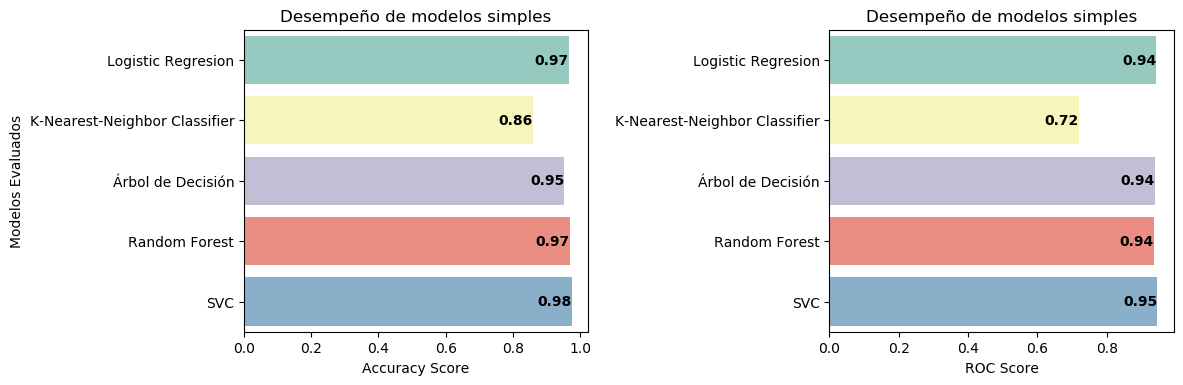

,Modelo,Accuracy_simple,ROC Score_simple
0,Logistic Regresion,0.97,0.94
1,K-Nearest-Neighbor Classifier,0.86,0.72
2,Árbol de Decisión,0.95,0.94
3,Random Forest,0.97,0.94
4,SVC,0.98,0.95


In [107]:
print('El desempeño de los modelos simples (vanilla) es:')
fig = plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.7)
plt.subplot(1, 2, 1)
ax = sns.barplot(y=metric['Modelo'],
                 x=metric['Accuracy_simple'],
                 palette="Set3")
# add annotations one by one with a loop
for i, v in enumerate(metric['Accuracy_simple'].iteritems()):
    ax.text(v[1],
            i,
            round(v[1], 2),
            ha='right',
            va='center',
            size='medium',
            color='black',
            weight='semibold')
plt.xlabel('Accuracy Score')
plt.title('Desempeño de modelos simples')
plt.ylabel('Modelos Evaluados')

plt.subplot(1, 2, 2)
ax = sns.barplot(y=metric['Modelo'],
                 x=metric['ROC Score_simple'],
                 palette="Set3")
# add annotations one by one with a loop
for i, v in enumerate(metric['ROC Score_simple'].iteritems()):
    ax.text(v[1],
            i,
            round(v[1], 2),
            ha='right',
            va='center',
            size='medium',
            color='black',
            weight='semibold')
plt.xlabel('ROC Score')
plt.title('Desempeño de modelos simples')
plt.ylabel('')
#plt.yticks('');

plt.show()
round(metric, 2)

Presentando Curva ROC:

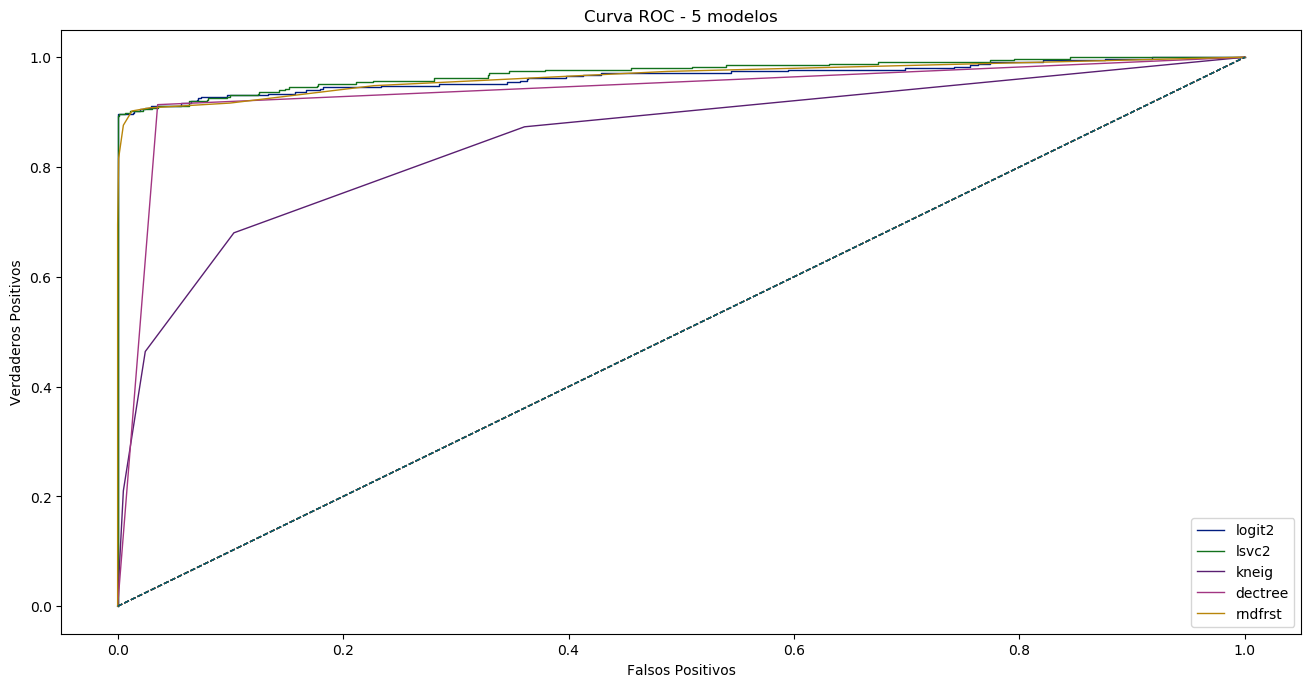

In [108]:
# Generando objetos de ROC curve
plt.figure(figsize=[16, 8])
plt.title('Curva ROC - 5 modelos')
for i, k in zip(
    [logit_model2, svc_model2, kneig_model, decTree_model, rndFrst_model],
    ['logit2', 'lsvc2', 'kneig', 'dectree', 'rndfrst']):
    a = pd.DataFrame(i.predict_proba(X_val2_std))[1]
    b = pd.DataFrame(i.predict(X_val2_std))
    fp, tp, th = roc_curve(y_val2, a)
    #accuracy_s  = accuracy_score(y_test2, b)
    #print(f'\033[1mEl desempeño del modelo {k} en base a la métrica Accuracy es:\033[0m\n')
    #print(pd.DataFrame({k: recall_s}, index=['accuracy']),"\n")
    #print(f"\n\033[1mMetricas para clases 0 y 1, modelo {k}\033[0m\n\n{classification_report(y_test2,b)}\n\n")
    plt.plot(fp, tp, lw=1, label='{}'.format(k))

    plt.plot([0, 1], ls='--', lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

_Comentarios:_ En las gráficas de desempeño despecto a la data del año 2010, se observa que el mejor comportamiento lo presenta el modelo _SVC_ que posee tanto la mayor exactitud en la predicción (Accuracy) de 98%, como mayor área bajo la curva ROC 95%. Posterior a ésta, los mejores modelos son la Regresión logística y Random Forest, donde ambos possen un ROC score similar a otros agoritmos 94%, y mayor exactitud en comparación 97%. Y el peor desempeño está dado por el algoritmo K-Nearest-Neighbor Classifier, con un accuracy de 86% y un ROC score de 72%.

En la curva ROC del gráfico presentado anteriormente, se observa que el modelo SVC posee una respuesta similar a la Regresión Logística y Random Forest, en relación a verdaderos positivos y falsos positivos.

## Modelación de algoritmos tuneados
A continuación se utilizará gridsearch para identificar cual es el mejor algoritmo aplicando mejoras de sus hiperparámetros. El modelo entrenado con la mejor combinación de valores se considera como el de mejor desempeño, y por lo tanto se evaluará con la data de prueba del año 2010.

In [ ]:
# Regresión Logística
# Definición de parámetros de Grilla
parameters_lr={"C":np.logspace(-3,3,7), "penalty":['l1','l2']}
# Búsqueda de mejor modelo
grid_rl = GridSearchCV(LogisticRegression(),parameters_lr, n_jobs=-1,scoring ='accuracy', cv=5, verbose=50).fit(X_train2_std, y_train2)
# Modelo entrenado con mejor tuneo de parámetros
grid_rl_best= grid_rl.best_estimator_
# Métrica
ac_grid_rl = accuracy_score(y_test2, grid_rl_best.predict(X_test2_std))
roc_grid_rl = roc_auc_score(y_test2, grid_rl_best.predict(X_test2_std))

print(f'Los mejores hiperparámetros del modelo Logistic Regresion son:\n{grid_rl.best_params_}')

In [ ]:
# K-Nearest-Neighbor Classifier
# Definición de parámetros de Grilla
parameters_knc={'n_neighbors': [3,5,11,19]}
# Búsqueda de mejor modelo
grid_knc = GridSearchCV(KNeighborsClassifier(),parameters_knc, n_jobs=-1,scoring ='accuracy', cv=5, verbose=50).fit(X_train2_std, y_train2)
# Modelo entrenado con mejor tuneo de parámetros
grid_knc_best= grid_knc.best_estimator_
# Métrica
ac_grid_knc = accuracy_score(y_test2, grid_knc_best.predict(X_test2_std))
roc_grid_knc = roc_auc_score(y_test2, grid_knc_best.predict(X_test2_std))

print(f'Los mejores hiperparámetros del modelo n_neighbors son:\n{grid_knc.best_params_}')

In [ ]:
# Árbol de decisión
# Definición de parámetros de Grilla
parameters_tree={'max_depth': np.linspace(1, 20, 5), "max_features":list(range(1,X_train2_std.shape[1],5)),
                 'min_samples_split': np.linspace(0.1, 1.0, 10)}
# Búsqueda de mejor modelo
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=123),parameters_tree, 
                       n_jobs=-1,scoring ='accuracy', cv=5, verbose=50).fit(X_train2_std, y_train2)
# Modelo entrenado con mejor tuneo de parámetros
grid_tree_best= grid_tree.best_estimator_
# Métrica
ac_grid_tree = accuracy_score(y_test2, grid_tree_best.predict(X_test2_std))
roc_grid_tree = roc_auc_score(y_test2, grid_tree_best.predict(X_test2_std))

print(f'Los mejores hiperparámetros del Árbol de Decisión son:\n{grid_tree.best_params_}')

In [ ]:
#Gridsearch Random Forest
# Definición de parámetros de Grilla
param_grid_rf = [{
    'n_estimators': [3, 10, 25],
    'max_features': [5, 15, 25],
    'max_depth': [10, 50, None],
    'bootstrap': [True, False],
    "criterion": ["gini", "entropy"]
}]

# Búsqueda de mejor modelo
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=180919),
                                  param_grid_rf,
                                  cv=5,
                                  scoring='accuracy',
                                  verbose=50,
                                  n_jobs=-1)
grid_search_rf.fit(X_train2_std, y_train2)

# Modelo entrenado con mejor tuneo de parámetros
grid_rf_best = grid_search_rf.best_estimator_

# Metricas
ac_grid_rf = accuracy_score(y_test2, grid_rf_best.predict(X_test2_std))
roc_grid_rf = roc_auc_score(y_test2, grid_rf_best.predict(X_test2_std))

print(f'Los mejores parámetros son:\n{grid_search_rf.best_params_}')

In [ ]:
#Gridsearch Support Vector Classifier

# Definición de parámetros de Grilla
param_grid_svc = [{'kernel': ['rbf'],'gamma': [0.0001, 0.001, 0.1, 1, 10],'C': [0.01, 1, 10, 100]}, 
                  {'kernel': ['linear'],'C': [0.01,1, 10, 100]}] 

# Búsqueda de mejor modelo
grid_search_svc = GridSearchCV(SVC(random_state=180919,probability=True),
                        param_grid_svc,
                        n_jobs=-1,
                        scoring='recall',
                        verbose=50,
                        cv=5)
grid_search_svc.fit(X_train2_std, y_train2)

# Modelo entrenado con mejor tuneo de parámetros
grid_svc_best_v = grid_search_svc.best_estimator_

# Metricas
ac_grid_svc = accuracy_score(y_test2, grid_svc_best_v.predict(X_test2_std))
roc_grid_svc = roc_auc_score(y_test2, grid_svc_best_v.predict(X_test2_std))

print(f'Los mejores parámetros son:\n{grid_search_svc.best_params_}')

In [114]:
metric_tun = pd.DataFrame({'Modelo Tuneado':['Logistic Regresion','K-Nearest-Neighbor Classifier','Árbol de Decisión',
                                 'Random Forest','SVC'],
                      'Accuracy': [ac_grid_rl , ac_grid_knc , ac_grid_tree , ac_grid_rf , ac_grid_svc],
                      'ROC Score': [roc_grid_rl , roc_grid_knc , roc_grid_tree , roc_grid_rf , roc_grid_svc]})

El desempeño de los modelos tuneados, respecto al año 2010, es:


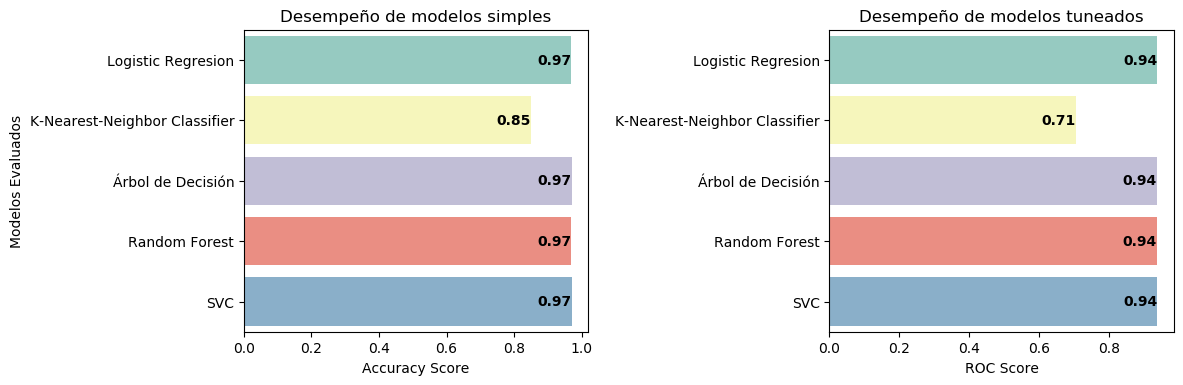

,Modelo Tuneado,Accuracy,ROC Score
0,Logistic Regresion,0.969678,0.939518
1,K-Nearest-Neighbor Classifier,0.850074,0.706267
2,Árbol de Decisión,0.970941,0.937500
3,Random Forest,0.969467,0.937171
4,SVC,0.971152,0.939216


In [115]:
print('El desempeño de los modelos tuneados, respecto al año 2010, es:')
fig = plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.7)
plt.subplot(1,2,1)
ax = sns.barplot(y=metric_tun['Modelo Tuneado'], x=metric_tun['Accuracy'], palette="Set3")
# add annotations one by one with a loop
for i, v in enumerate(metric_tun['Accuracy'].iteritems()):
    ax.text(v[1], i, round(v[1],2), ha='right', va='center', size='medium', color='black', weight='semibold')
plt.xlabel('Accuracy Score');
plt.title('Desempeño de modelos simples');
plt.ylabel('Modelos Evaluados');

plt.subplot(1,2,2)
ax = sns.barplot(y=metric_tun['Modelo Tuneado'], x=metric_tun['ROC Score'], palette="Set3")
# add annotations one by one with a loop
for i, v in enumerate(metric_tun['ROC Score'].iteritems()):
    ax.text(v[1], i, round(v[1],2), ha='right', va='center', size='medium', color='black', weight='semibold')
plt.xlabel('ROC Score');
plt.title('Desempeño de modelos tuneados');
plt.ylabel('');
#plt.yticks('');

plt.show()
metric_tun

#### Curva ROC con modelos tunneados

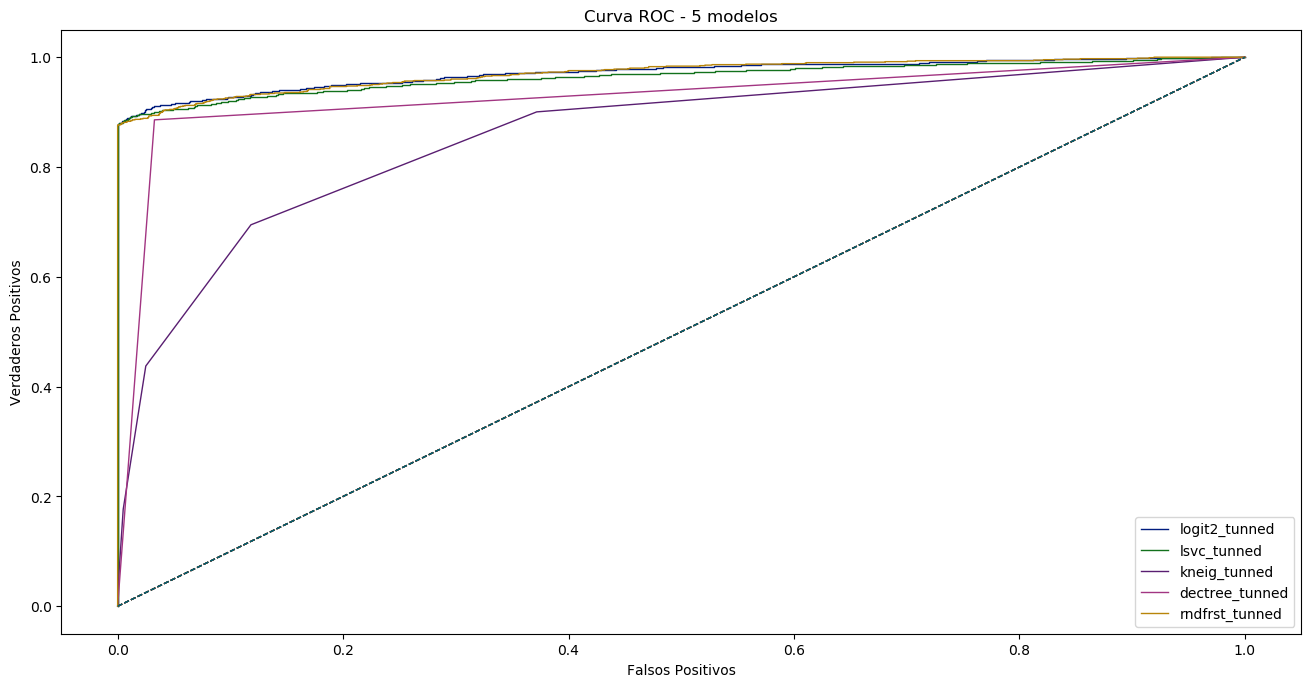

In [118]:
# Generando objetos de ROC curve
plt.figure(figsize=[16,8])
plt.title('Curva ROC - 5 modelos')
for i, k in zip([grid_rl_best, grid_svc_best_v, kneig_model, decTree_model, grid_rf_best],['logit2_tunned', 'lsvc_tunned', 'kneig_tunned', 'dectree_tunned', 'rndfrst_tunned']):
    a = pd.DataFrame(i.predict_proba(X_test2_std))[1]
    b = pd.DataFrame(i.predict(X_test2_std))
    fp, tp, th = roc_curve(y_test2, a)
    accuracy_s  = accuracy_score(y_test2, b)
    #print(f'\033[1mEl desempeño del modelo {k} en base a la métrica Accuracy es:\033[0m\n')
    #print(pd.DataFrame({k: recall_s}, index=['accuracy']),"\n")
    #print(f"\n\033[1mMetricas para clases 0 y 1, modelo {k}\033[0m\n\n{classification_report(y_test2,b)}\n\n")
    plt.plot(fp, tp, lw=1, label='{}'.format(k))

    plt.plot([0,1], ls='--', lw=1)
plt.ylabel('Verdaderos Positivos')
plt.xlabel('Falsos Positivos')
plt.legend()
plt.show()

__Comentarios:__ En general se observa que 4 de los 5 modelos presentan un desempeño similar en torno a 97% en accuracy y 94% en recall. Estos modelos son: regresión logística, árbol de decisión, random forest y CSV. Mientras que el peor desempeño lo muestra K-Nearest-Neighbor Classifier. 

Es llamativo que todos los modelos tuneados lleguen a un mismo nivel de en ambas métricas, es posible que esto se deba a que la naturaleza del problema presenta un límite de desempeño y frente a las características entregadas no se puede llegar más allá de estos valores. Es posible que se puedan observar mayores cambios si se agregara una mayor cantidad de datos.

## 5. Serialización de modelos
Seleccione los 2 mejores modelos, serialicelos y envíelos a evaluación. Recuerde que el modelo serializado debe ser posterior al fit , para poder ejecutar predict en los nuevos datos.

---

Se guardará un modelo para el problema de arrestos, y dos modelos distintos para el problema de violencia. Cuando se utilice el modelo se debe realizar el Feature Engineering en la data, utilizando la función __df_preprocess__.

__Forma de uso de la función__: 

at_train_bin, at_test_bin, vo_train_bin, vo_test_bin, df_train_pp, df_test_pp, categoricos, numericos = df_preprocess(df_train.copy(),df_test.copy(),y_list)

Para cualquier modelo, los 4 dataframes relevantes serían:
- at_train_bin = atributos de entrenamiento binarizados
- at_test_bin = atributos de testeo binarizados
- vo_train_bin = variables objetivos de entrenamiento binarizadas
- vo_test_bin = variables objetivos de testeo binarizadas


- Procedimientos policiales que concluyeron en un arresto.

En este caso se observaron dos modelos con mejor desempeño, uno en Recall y otro en Accuracy. Debido al alto desbalance entre las clases, y considerando que este modelo predice si una persona es arresta o no, se considera como 'mejor modelo' el que presenta un mejor Recall.

In [119]:
# Guardando modelo 1 - Arrestos
pickle_out_arrestos = open('ModeloArrestos_Prueba2_LosPerceptrones.sav','wb')
pickle.dump(grid_rf_best_arr, pickle_out_arrestos)
pickle_out_arrestos.close()

- Procedimientos policiales que concluyeron en una acción violenta

Dado que 4 modelos presentaron un score similar en exactitud y ROC, se escogerá a los modelos que presenten mejor ROC Score, ya que representa de mejor manera el resultado del modelo considerando el desbalance presente de las clases. Por lo tanto, se serializarán el modelo __SVC__ (93.92%) y __Regresión Logística__ (93.95%).

In [120]:
# Guardando modelo 1 - Violencia - SCV
pickle_out_m1_violencia = open('Modelo1_violencia_Prueba2_LosPerceptrones.sav','wb')
pickle.dump(grid_svc_best_v, pickle_out_m1_violencia)
pickle_out_m1_violencia.close()

In [121]:
# Guardando modelo 2 - Violencia - Regresión Logística
pickle_out_m2_violencia = open('Modelo2_violencia_Prueba2_LosPerceptrones.sav','wb')
pickle.dump(grid_rl_best, pickle_out_m2_violencia)
pickle_out_m2_violencia.close()